In [1]:
pip install tslearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.signal import savgol_filter as svgl
import statsmodels.api as sm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.cm as cm


In [3]:
df = pd.read_excel(r'cons_data_all_res (1).xlsx')
df.head(5)



Time  year  moy_date  doy_date  busday  season  dow_date  \
0 2017-01-01 00:00:00  2017         1         1   False  Winter         1   
1 2017-01-01 01:00:00  2017         1         1   False  Winter         1   
2 2017-01-01 02:00:00  2017         1         1   False  Winter         1   
3 2017-01-01 03:00:00  2017         1         1   False  Winter         1   
4 2017-01-01 04:00:00  2017         1         1   False  Winter         1   

   hour month_name  temp  ...      r3      r4      r5      r6      r7      r8  \
0     0  January    22.0  ...  0.0821  0.0667  0.2131  0.0854  0.1277  0.2173   
1     1  January    22.0  ...  0.0989  0.1047  0.1719  0.0948  0.1112  0.2411   
2     2  January    22.0  ...  0.0990  0.1001  0.1865  0.0978  0.1850  0.8316   
3     3  January    23.5  ...  0.1038  0.1354  0.1882  0.1064  0.0970  0.6645   
4     4  January    27.0  ...  0.0780  0.3508  0.2092  0.2456  0.1374  1.9451   

       r9     r10     r11     r12  
0  0.1478  0.1568  1.1462  0.2553  
1  0.1597  0.4315  0.2193  0.5326  
2  0.2118  1.4843  0.1563  0.3818  
3  0.2361  1.3716  0.2327  0.3798  
4  0.3902  0.2105  0.2395  0.5176  

[5 rows x 23 columns]

In [4]:
df.shape

(8760, 23)

In [5]:
a = df.describe()
print(a)

         year     moy_date     doy_date     dow_date         hour  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.000000   
mean   2017.0     6.526027   183.000000     3.991781    11.500000   
std       0.0     3.448048   105.372043     2.003519     6.922582   
min    2017.0     1.000000     1.000000     1.000000     0.000000   
25%    2017.0     4.000000    92.000000     2.000000     5.750000   
50%    2017.0     7.000000   183.000000     4.000000    11.500000   
75%    2017.0    10.000000   274.000000     6.000000    17.250000   
max    2017.0    12.000000   365.000000     7.000000    23.000000   

              temp        humid           r1           r2           r3  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     28.658419    66.912808     0.224942     0.228293     0.239121   
std       2.851937    18.325252     0.139805     0.196766     0.213277   
min      17.500000    14.160000     0.010500     0.004400     0.010800   
25%     

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        8760 non-null   datetime64[ns]
 1   year        8760 non-null   int64         
 2   moy_date    8760 non-null   int64         
 3   doy_date    8760 non-null   int64         
 4   busday      8760 non-null   bool          
 5   season      8760 non-null   object        
 6   dow_date    8760 non-null   int64         
 7   hour        8760 non-null   int64         
 8   month_name  8760 non-null   object        
 9   temp        8760 non-null   float64       
 10  humid       8760 non-null   float64       
 11  r1          8760 non-null   float64       
 12  r2          8760 non-null   float64       
 13  r3          8760 non-null   float64       
 14  r4          8760 non-null   float64       
 15  r5          8760 non-null   float64       
 16  r6          8760 non-nul

In [7]:
#handling missing values
missing_values = df.isnull().values.any()
missing_values

False

In [8]:
nan = df.isnull().sum()
print(nan[nan != 0])
'''No Null Values'''

Series([], dtype: int64)


'No Null Values'

In [9]:
season = df['season'].value_counts()
season

Monsoon    2952
Summer     2928
Winter     2880
Name: season, dtype: int64

In [10]:
day_type = df['busday'].value_counts()
day_type

True     5976
False    2784
Name: busday, dtype: int64

In [11]:
df.columns
#index_columns_when_required
columns_index_temp = ['Time','year', 'moy_date', 'doy_date', 'busday', 'season', 'dow_date', 'hour',
       'month_name', 'temp', 'humid']
len(df)

8760

In [12]:
df1 = df.copy()
df2 = df.copy()
df1 = df1.set_index(columns_index_temp)

correlation_matrix = df1.corr()
print(correlation_matrix)
correlation_matrix.size
#meter values not correlated with each other 

           r1        r2        r3        r4        r5        r6        r7  \
r1   1.000000 -0.019204  0.052913  0.095047  0.084175  0.082733  0.150884   
r2  -0.019204  1.000000  0.057535  0.091947  0.043274  0.110214  0.077554   
r3   0.052913  0.057535  1.000000  0.076965  0.111725  0.248240  0.110788   
r4   0.095047  0.091947  0.076965  1.000000  0.138301  0.103235  0.141575   
r5   0.084175  0.043274  0.111725  0.138301  1.000000  0.180115  0.092182   
r6   0.082733  0.110214  0.248240  0.103235  0.180115  1.000000  0.138243   
r7   0.150884  0.077554  0.110788  0.141575  0.092182  0.138243  1.000000   
r8   0.196319  0.051140  0.043062  0.174623  0.141254  0.133624  0.106078   
r9   0.046691  0.118133  0.215027  0.080676  0.237884  0.379834  0.180632   
r10  0.129816  0.125227  0.175034  0.164283  0.123046  0.289322  0.147466   
r11  0.045753  0.169754  0.140930  0.176780  0.082823  0.128822  0.129095   
r12 -0.026275  0.223436  0.190310  0.172544  0.090124  0.248709  0.078529   

144

In [13]:
#CREATE DATA FUNCTIONS

#getting individual meter with respect to data
def get_column_df(df, column_name):
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the df.")
        return pd.DataFrame()
    
    df = df.set_index(columns_index_temp)
    filtered_df = pd.DataFrame(df[column_name])
    filtered_df.reset_index(drop=False, inplace=True)
    filtered_df.set_index('Time',inplace = True)


    return filtered_df

def get_multiple_timeseries(df1,):
    df1.set_index('Time',inplace = True)
    df2 = df1.drop(columns = ['year', 'moy_date', 'doy_date', 'busday', 'season', 'dow_date', 'hour',
       'month_name', 'temp', 'humid'],axis = 1)
    return df2


#train-test-split function
def get_train_test(df,):
    
    train_len = int(.8*len(df))
    train_df = df.iloc[:train_len].copy()
    test_df = df.iloc[train_len:].copy()
    return train_df,test_df
    

## smoothing function
def savgol(x, window_length=9, polyorder=6): 
    y = svgl(x, window_length, polyorder)
    return pd.Series(y, index=x.index)

def trend(x): ## passing parameter to smoothing function
    #print(x)
    return savgol(x, 21, 3)


In [14]:
#dataframe with all the meters w.r.t to timestamp
df_r = get_multiple_timeseries(df2)
df_r

r1      r2      r3      r4      r5      r6      r7  \
Time                                                                          
2017-01-01 00:00:00  0.1338  0.6225  0.0821  0.0667  0.2131  0.0854  0.1277   
2017-01-01 01:00:00  0.1539  0.4753  0.0989  0.1047  0.1719  0.0948  0.1112   
2017-01-01 02:00:00  0.3061  0.7379  0.0990  0.1001  0.1865  0.0978  0.1850   
2017-01-01 03:00:00  0.3564  0.2106  0.1038  0.1354  0.1882  0.1064  0.0970   
2017-01-01 04:00:00  0.3306  0.1353  0.0780  0.3508  0.2092  0.2456  0.1374   
...                     ...     ...     ...     ...     ...     ...     ...   
2017-12-31 19:00:00  0.1499  0.2189  0.0447  0.0896  0.1475  0.0889  0.1258   
2017-12-31 20:00:00  0.1475  0.1456  0.0223  0.0584  0.1649  0.0883  0.1166   
2017-12-31 21:00:00  0.1500  0.1353  0.0521  0.1000  0.1887  0.0977  0.0997   
2017-12-31 22:00:00  0.1502  0.1113  0.0485  0.1067  0.1874  0.0950  0.1459   
2017-12-31 23:00:00  0.1489  0.1121  0.0293  0.0600  0.1898  0.0885  0.1009   

                         r8      r9     r10     r11     r12  
Time                                                         
2017-01-01 00:00:00  0.2173  0.1478  0.1568  1.1462  0.2553  
2017-01-01 01:00:00  0.2411  0.1597  0.4315  0.2193  0.5326  
2017-01-01 02:00:00  0.8316  0.2118  1.4843  0.1563  0.3818  
2017-01-01 03:00:00  0.6645  0.2361  1.3716  0.2327  0.3798  
2017-01-01 04:00:00  1.9451  0.3902  0.2105  0.2395  0.5176  
...                     ...     ...     ...     ...     ...  
2017-12-31 19:00:00  0.1211  0.1620  0.1375  0.5079  0.1471  
2017-12-31 20:00:00  0.1056  0.1639  0.1367  0.1133  0.1921  
2017-12-31 21:00:00  0.1052  0.1642  0.1791  0.1159  0.1581  
2017-12-31 22:00:00  0.1232  0.1654  0.1425  0.4760  0.2320  
2017-12-31 23:00:00  0.1025  0.1606  0.1343  0.1131  0.2954  

[8760 rows x 12 columns]

In [15]:
#min-max scaling
time_series_cols = df_r.columns

df_individual_scaled = df_r.copy()
for col in time_series_cols:
    scaler1 = MinMaxScaler()
    df_individual_scaled[col] = scaler1.fit_transform(df_individual_scaled[[col]])
df_individual_scaled 


r1        r2        r3        r4        r5  \
Time                                                                    
2017-01-01 00:00:00  0.064602  0.235413  0.029219  0.010976  0.085324   
2017-01-01 01:00:00  0.075134  0.179349  0.036104  0.017905  0.067623   
2017-01-01 02:00:00  0.154878  0.279365  0.036145  0.017066  0.073896   
2017-01-01 03:00:00  0.181232  0.078534  0.038112  0.023503  0.074626   
2017-01-01 04:00:00  0.167715  0.049855  0.027539  0.062777  0.083648   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.073038  0.081696  0.013892  0.015152  0.057140   
2017-12-31 20:00:00  0.071780  0.053778  0.004713  0.009463  0.064616   
2017-12-31 21:00:00  0.073090  0.049855  0.016925  0.017048  0.074841   
2017-12-31 22:00:00  0.073195  0.040715  0.015450  0.018270  0.074283   
2017-12-31 23:00:00  0.072514  0.041019  0.007581  0.009755  0.075314   

                           r6        r7        r8        r9       r10  \
Time                                                                    
2017-01-01 00:00:00  0.009689  0.023209  0.055281  0.040639  0.047958   
2017-01-01 01:00:00  0.013025  0.019402  0.061637  0.044222  0.137943   
2017-01-01 02:00:00  0.014090  0.036428  0.219335  0.059905  0.482818   
2017-01-01 03:00:00  0.017142  0.016126  0.174710  0.067221  0.445900   
2017-01-01 04:00:00  0.066546  0.025446  0.516704  0.113610  0.065549   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.010931  0.022770  0.029590  0.044914  0.041635   
2017-12-31 20:00:00  0.010718  0.020648  0.025451  0.045486  0.041373   
2017-12-31 21:00:00  0.014055  0.016749  0.025344  0.045576  0.055263   
2017-12-31 22:00:00  0.013096  0.027407  0.030151  0.045938  0.043273   
2017-12-31 23:00:00  0.010789  0.017026  0.024623  0.044493  0.040587   

                          r11       r12  
Time                                     
2017-01-01 00:00:00  0.254192  0.066373  
2017-01-01 01:00:00  0.045021  0.140978  
2017-01-01 02:00:00  0.030804  0.100406  
2017-01-01 03:00:00  0.048045  0.099868  
2017-01-01 04:00:00  0.049579  0.136942  
...                       ...       ...  
2017-12-31 19:00:00  0.110148  0.037262  
2017-12-31 20:00:00  0.021100  0.049369  
2017-12-31 21:00:00  0.021687  0.040222  
2017-12-31 22:00:00  0.102949  0.060104  
2017-12-31 23:00:00  0.021055  0.077161  

[8760 rows x 12 columns]

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\3691450132.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


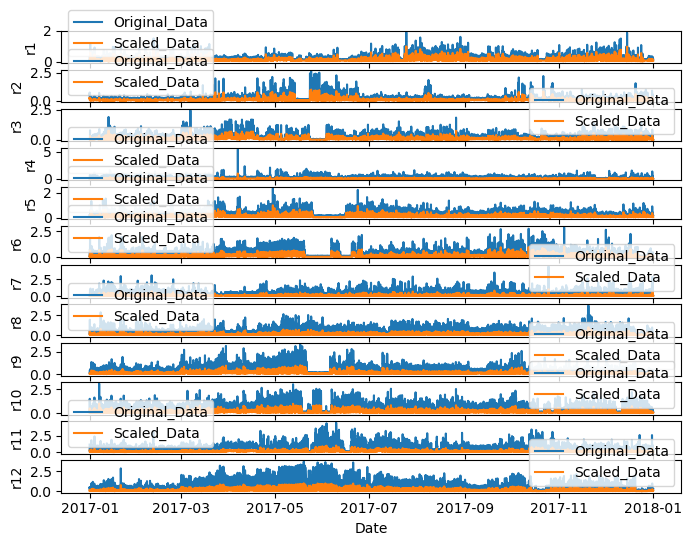

In [16]:
fig, axes = plt.subplots(len(time_series_cols), 1, figsize=(8, 6))
#comparison plot
for i, col in enumerate(time_series_cols):
    axes[i].plot(df['Time'], df_r[col], label='Original_Data')
    axes[i].plot(df['Time'], df_individual_scaled[col], label='Scaled_Data')

    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [17]:
df_r = df_individual_scaled
df_individual_scaled

r1        r2        r3        r4        r5  \
Time                                                                    
2017-01-01 00:00:00  0.064602  0.235413  0.029219  0.010976  0.085324   
2017-01-01 01:00:00  0.075134  0.179349  0.036104  0.017905  0.067623   
2017-01-01 02:00:00  0.154878  0.279365  0.036145  0.017066  0.073896   
2017-01-01 03:00:00  0.181232  0.078534  0.038112  0.023503  0.074626   
2017-01-01 04:00:00  0.167715  0.049855  0.027539  0.062777  0.083648   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.073038  0.081696  0.013892  0.015152  0.057140   
2017-12-31 20:00:00  0.071780  0.053778  0.004713  0.009463  0.064616   
2017-12-31 21:00:00  0.073090  0.049855  0.016925  0.017048  0.074841   
2017-12-31 22:00:00  0.073195  0.040715  0.015450  0.018270  0.074283   
2017-12-31 23:00:00  0.072514  0.041019  0.007581  0.009755  0.075314   

                           r6        r7        r8        r9       r10  \
Time                                                                    
2017-01-01 00:00:00  0.009689  0.023209  0.055281  0.040639  0.047958   
2017-01-01 01:00:00  0.013025  0.019402  0.061637  0.044222  0.137943   
2017-01-01 02:00:00  0.014090  0.036428  0.219335  0.059905  0.482818   
2017-01-01 03:00:00  0.017142  0.016126  0.174710  0.067221  0.445900   
2017-01-01 04:00:00  0.066546  0.025446  0.516704  0.113610  0.065549   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.010931  0.022770  0.029590  0.044914  0.041635   
2017-12-31 20:00:00  0.010718  0.020648  0.025451  0.045486  0.041373   
2017-12-31 21:00:00  0.014055  0.016749  0.025344  0.045576  0.055263   
2017-12-31 22:00:00  0.013096  0.027407  0.030151  0.045938  0.043273   
2017-12-31 23:00:00  0.010789  0.017026  0.024623  0.044493  0.040587   

                          r11       r12  
Time                                     
2017-01-01 00:00:00  0.254192  0.066373  
2017-01-01 01:00:00  0.045021  0.140978  
2017-01-01 02:00:00  0.030804  0.100406  
2017-01-01 03:00:00  0.048045  0.099868  
2017-01-01 04:00:00  0.049579  0.136942  
...                       ...       ...  
2017-12-31 19:00:00  0.110148  0.037262  
2017-12-31 20:00:00  0.021100  0.049369  
2017-12-31 21:00:00  0.021687  0.040222  
2017-12-31 22:00:00  0.102949  0.060104  
2017-12-31 23:00:00  0.021055  0.077161  

[8760 rows x 12 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

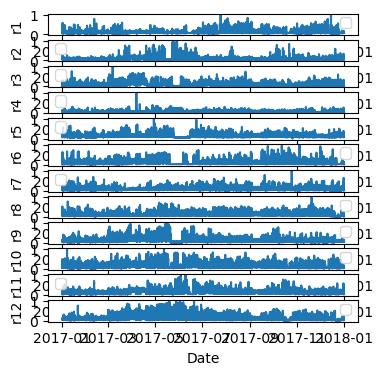

In [18]:
fig, axes = plt.subplots(len(time_series_cols), 1, figsize=(4, 4))
#individual scaling plot
for i, col in enumerate(time_series_cols):
    #axes[i].plot(df['Time'], df_r[col], label='Original')
    axes[i].plot(df['Time'], df_individual_scaled[col])
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

DATA IS ALREADY SCALED AND CLEANED

In [19]:
#CHECKING CORRELATION BETWEEN FEATURES
corr_df1= df.corr(method='spearman')
corr_df2= df.corr(method = 'pearson')
corr_df = df.corr()
corr_df1 ,corr_df2,corr_df

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\3434016129.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df1= df.corr(method='spearman')
C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\3434016129.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df2= df.corr(method = 'pearson')
C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\3434016129.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


(          year  moy_date  doy_date    busday  dow_date      hour      temp  \
 year       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 moy_date   NaN  1.000000  0.996517 -0.003418  0.012405  0.000000 -0.026994   
 doy_date   NaN  0.996517  1.000000 -0.003965  0.011799  0.000000 -0.024701   
 busday     NaN -0.003418 -0.003965  1.000000  0.009958  0.000000  0.022278   
 dow_date   NaN  0.012405  0.011799  0.009958  1.000000  0.000000 -0.001748   
 hour       NaN  0.000000  0.000000  0.000000  0.000000  1.000000 -0.181418   
 temp       NaN -0.026994 -0.024701  0.022278 -0.001748 -0.181418  1.000000   
 humid      NaN  0.193517  0.190438 -0.001273  0.006772  0.115634 -0.284272   
 r1         NaN  0.118497  0.113797 -0.024419 -0.006005 -0.352660  0.103123   
 r2         NaN  0.069876  0.066585  0.044314  0.026005  0.056236  0.133909   
 r3         NaN -0.099413 -0.103874  0.009901  0.003530 -0.188792  0.227132   
 r4         NaN -0.117655 -0.120223  0.001699 -0.033

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'year'),
  Text(0, 1.5, 'moy_date'),
  Text(0, 2.5, 'doy_date'),
  Text(0, 3.5, 'busday'),
  Text(0, 4.5, 'dow_date'),
  Text(0, 5.5, 'hour'),
  Text(0, 6.5, 'temp'),
  Text(0, 7.5, 'humid'),
  Text(0, 8.5, 'r1'),
  Text(0, 9.5, 'r2'),
  Text(0, 10.5, 'r3'),
  Text(0, 11.5, 'r4'),
  Text(0, 12.5, 'r5'),
  Text(0, 13.5, 'r6'),
  Text(0, 14.5, 'r7'),
  Text(0, 15.5, 'r8'),
  Text(0, 16.5, 'r9'),
  Text(0, 17.5, 'r10'),
  Text(0, 18.5, 'r11'),
  Text(0, 19.5, 'r12')])

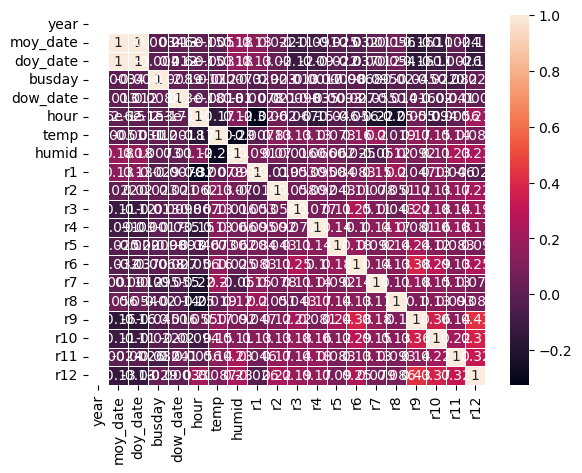

In [20]:
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [48]:
corr_df = df_r.corr(method='spearman')
corr_df

r1        r2        r3        r4        r5        r6        r7  \
r1   1.000000  0.020276  0.203566  0.242937  0.166368  0.270164  0.262406   
r2   0.020276  1.000000  0.088960  0.084301  0.062803  0.064104  0.091299   
r3   0.203566  0.088960  1.000000  0.275936  0.263197  0.381039  0.320989   
r4   0.242937  0.084301  0.275936  1.000000  0.233736  0.266369  0.372888   
r5   0.166368  0.062803  0.263197  0.233736  1.000000  0.294430  0.193527   
r6   0.270164  0.064104  0.381039  0.266369  0.294430  1.000000  0.279573   
r7   0.262406  0.091299  0.320989  0.372888  0.193527  0.279573  1.000000   
r8   0.318295  0.018638  0.199453  0.333043  0.262202  0.264802  0.263975   
r9   0.182206  0.066514  0.366380  0.216278  0.371469  0.376398  0.313600   
r10  0.274985  0.111256  0.305214  0.295383  0.234253  0.355579  0.306950   
r11  0.193267  0.169391  0.254476  0.294713  0.160801  0.227850  0.275091   
r12  0.084133  0.156624  0.202714  0.167494  0.203073  0.126941  0.154812   

           r8        r9       r10       r11       r12  
r1   0.318295  0.182206  0.274985  0.193267  0.084133  
r2   0.018638  0.066514  0.111256  0.169391  0.156624  
r3   0.199453  0.366380  0.305214  0.254476  0.202714  
r4   0.333043  0.216278  0.295383  0.294713  0.167494  
r5   0.262202  0.371469  0.234253  0.160801  0.203073  
r6   0.264802  0.376398  0.355579  0.227850  0.126941  
r7   0.263975  0.313600  0.306950  0.275091  0.154812  
r8   1.000000  0.206062  0.238498  0.217309  0.154095  
r9   0.206062  1.000000  0.359313  0.253298  0.331279  
r10  0.238498  0.359313  1.000000  0.266007  0.253201  
r11  0.217309  0.253298  0.266007  1.000000  0.286666  
r12  0.154095  0.331279  0.253201  0.286666  1.000000

In [ ]:
#heatmap
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'r1'),
  Text(0, 1.5, 'r2'),
  Text(0, 2.5, 'r3'),
  Text(0, 3.5, 'r4'),
  Text(0, 4.5, 'r5'),
  Text(0, 5.5, 'r6'),
  Text(0, 6.5, 'r7'),
  Text(0, 7.5, 'r8'),
  Text(0, 8.5, 'r9'),
  Text(0, 9.5, 'r10'),
  Text(0, 10.5, 'r11'),
  Text(0, 11.5, 'r12')])

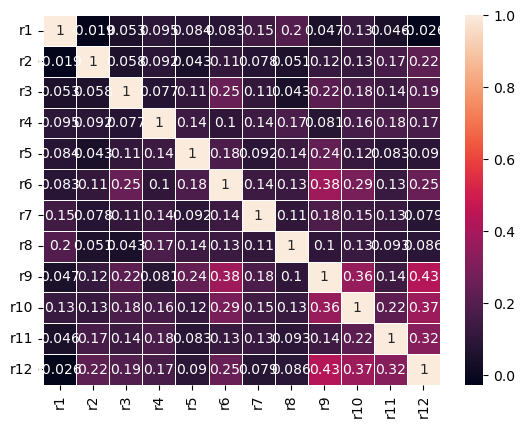

In [23]:
corr2_df = df_r.corr(method = 'pearson')

sns.heatmap(corr2_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [24]:
#DATA splitted into hourly,daily,monthly,seasonal timestamps
df_monthly = df_r.resample('M').mean()
df_seasonal = df_r.resample('4M').mean()
df_hourly = df_r.resample('H').mean()
df_daily = df_r.resample('D').mean()

In [25]:
###DATA VISUALIZATION of the meter readings for seasonal, monthly, daily, and hourly measurements

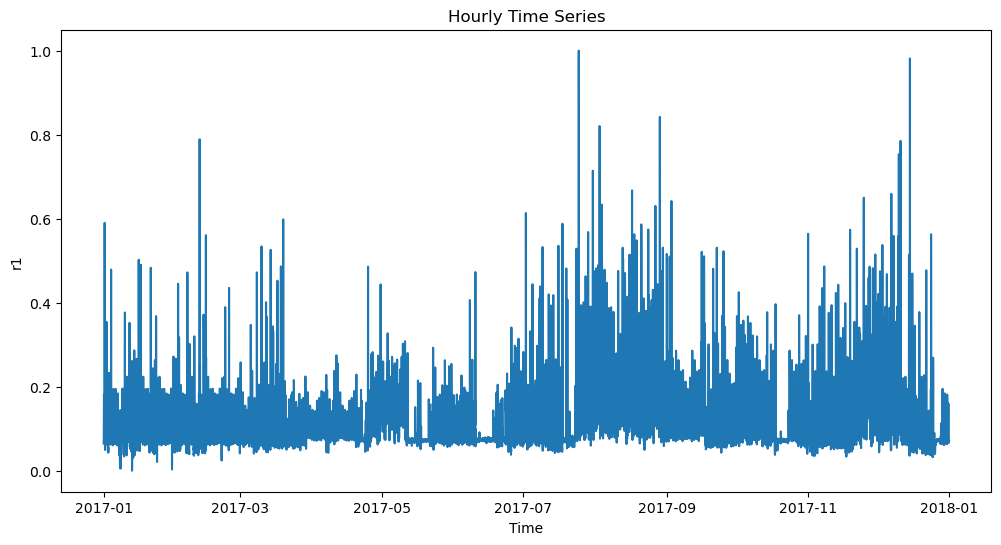

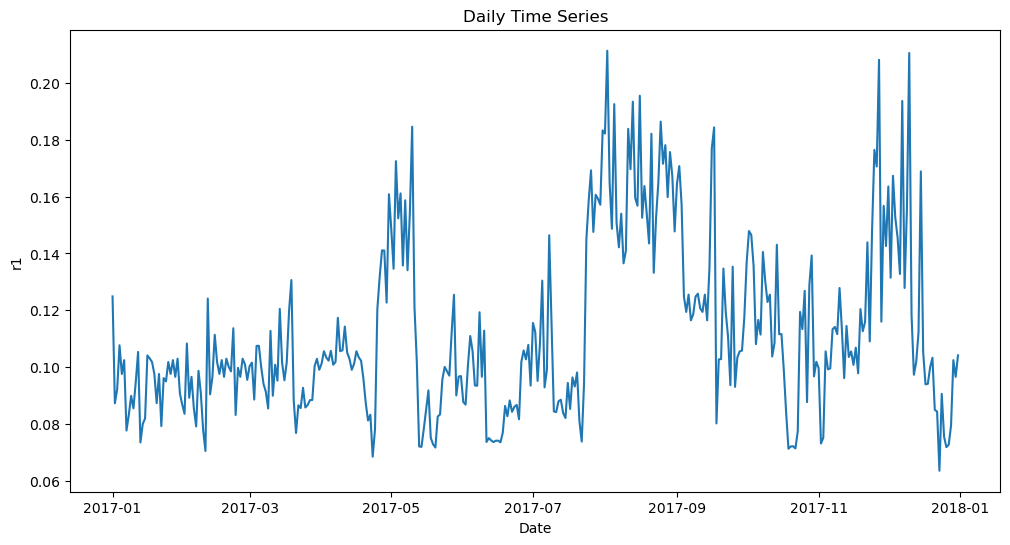

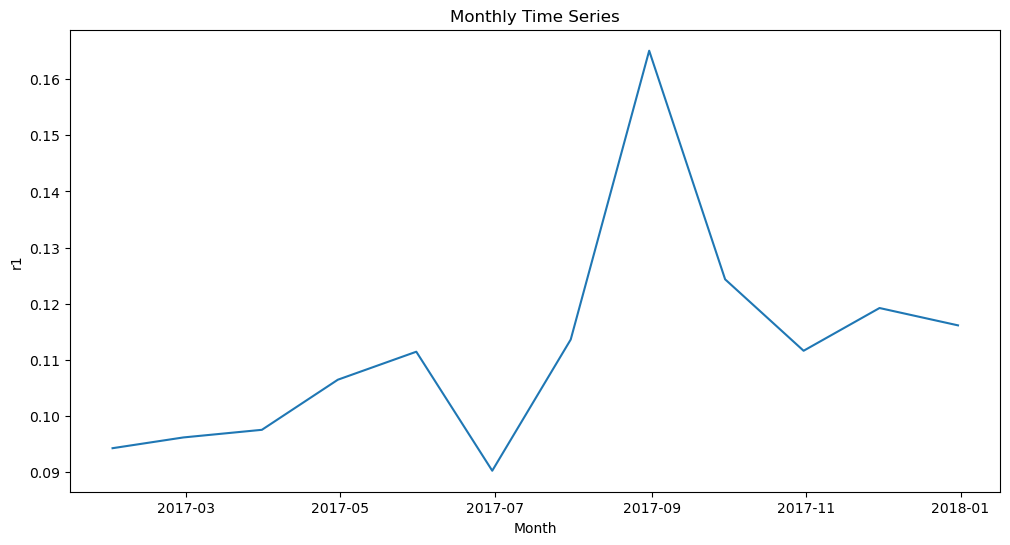

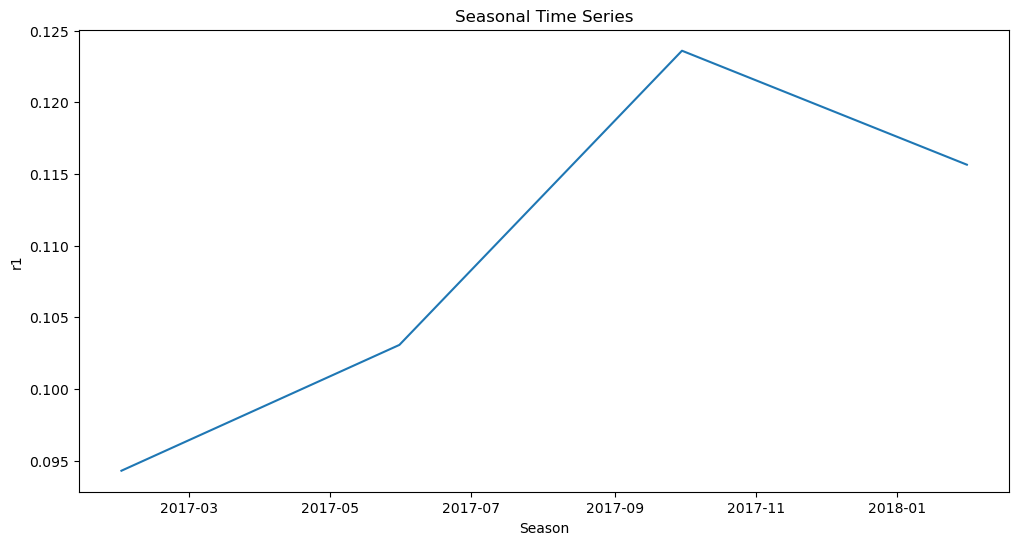

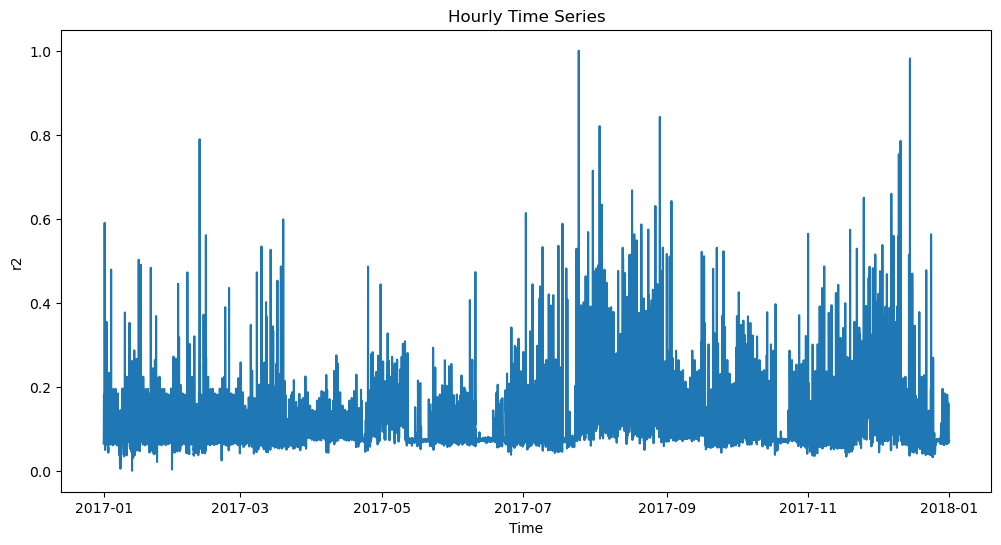

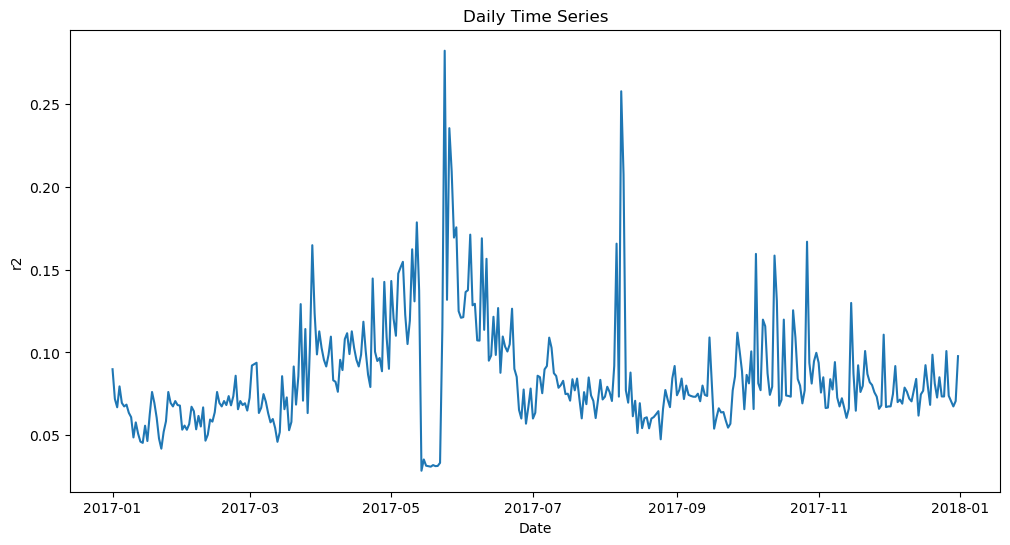

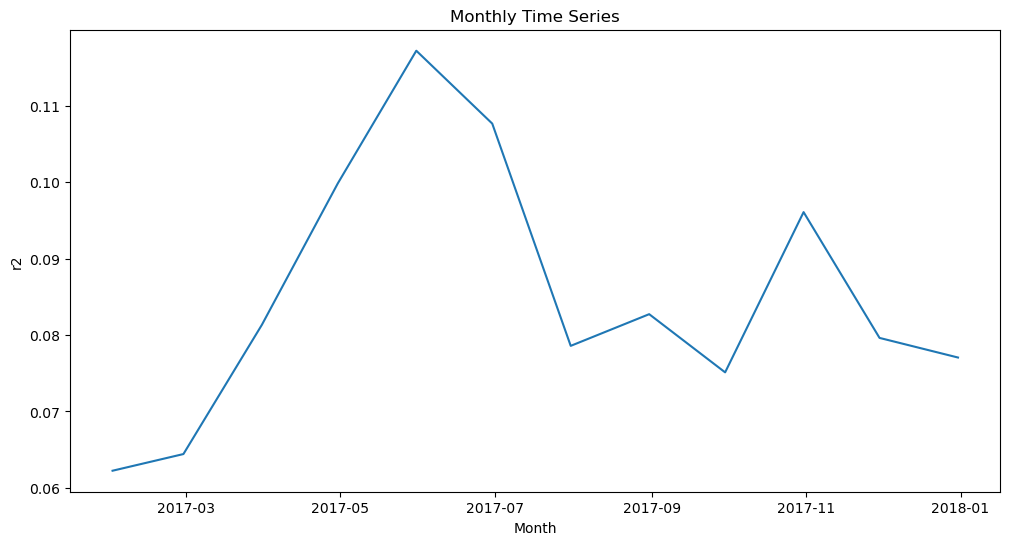

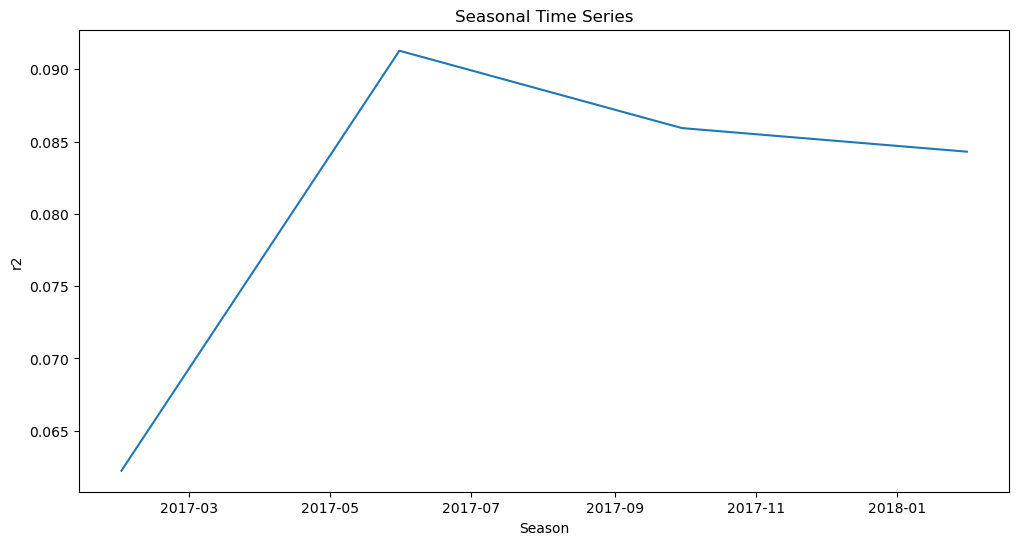

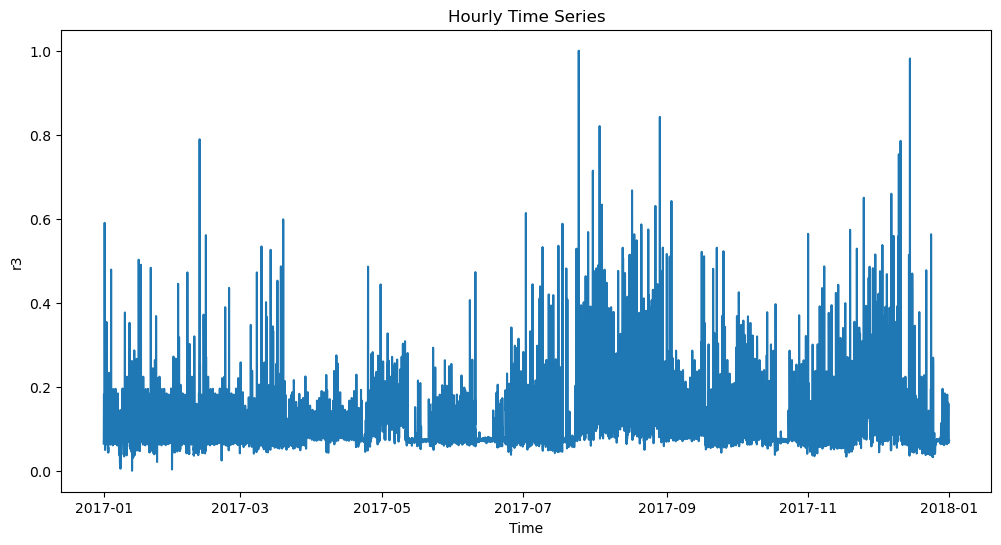

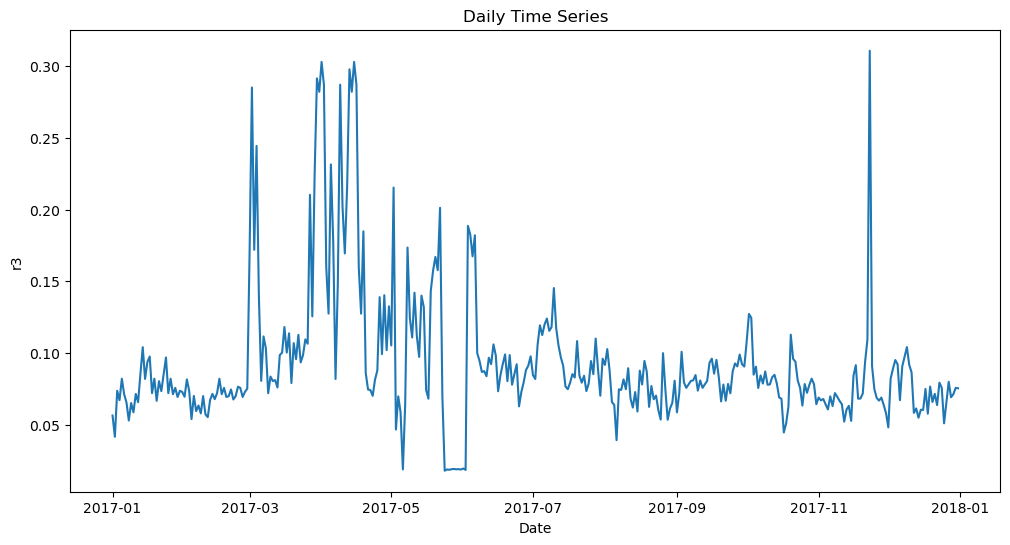

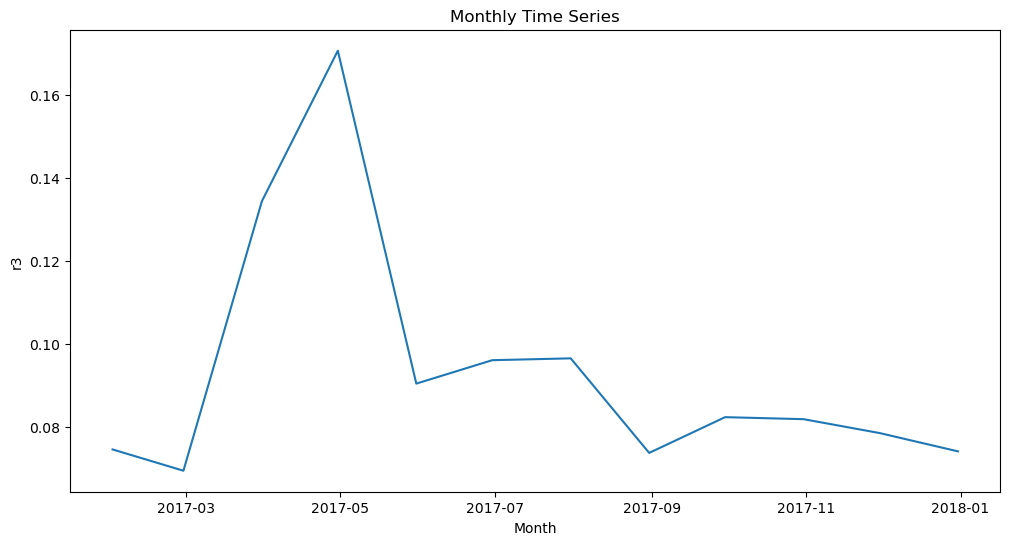

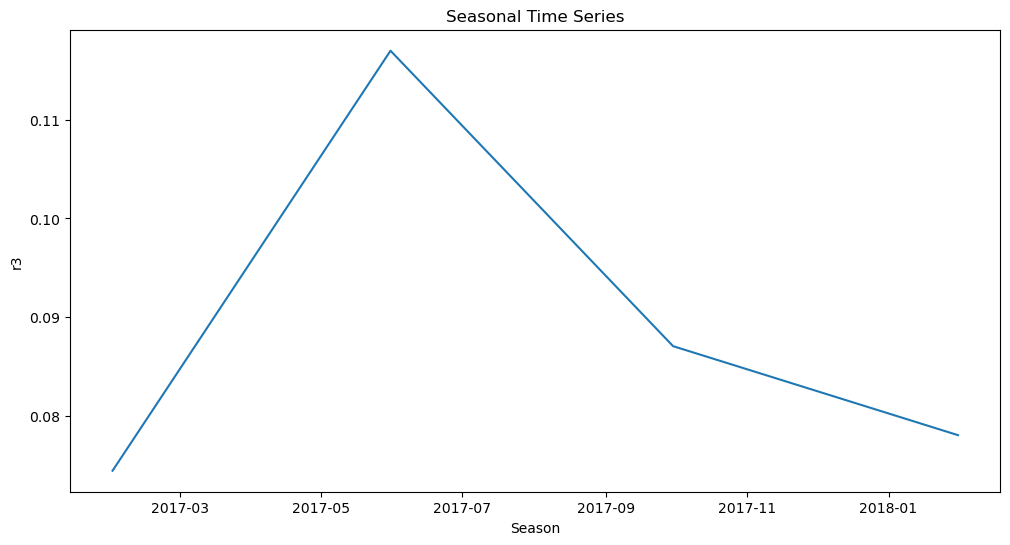

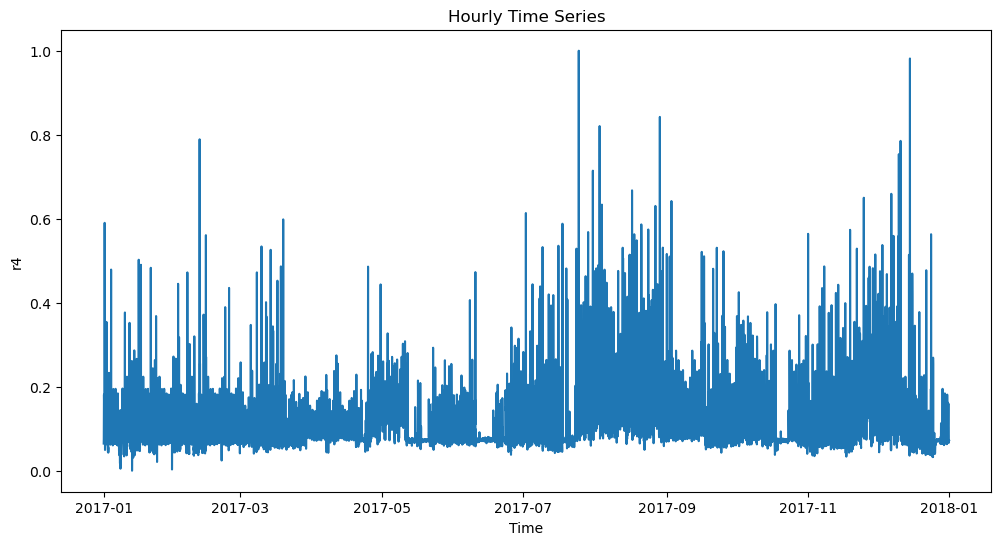

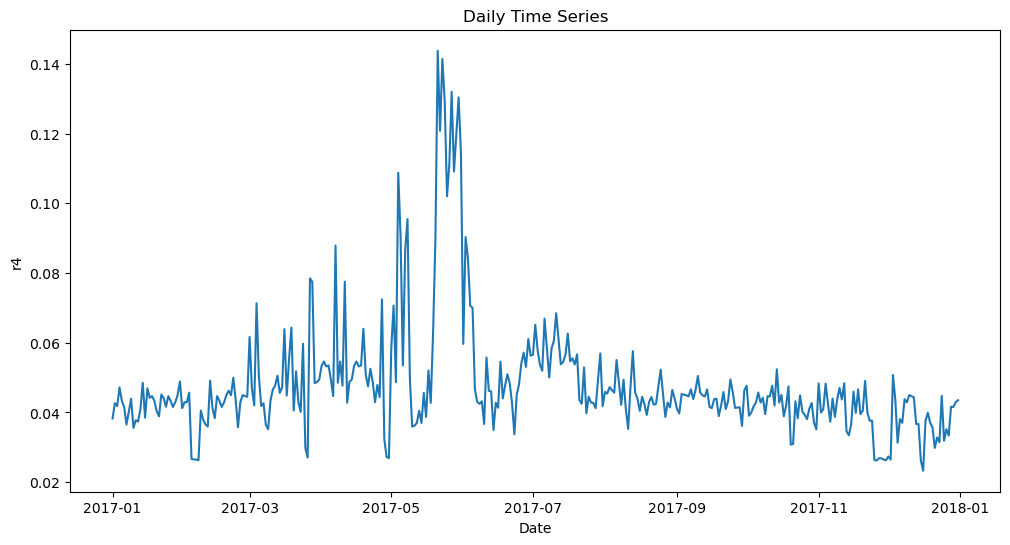

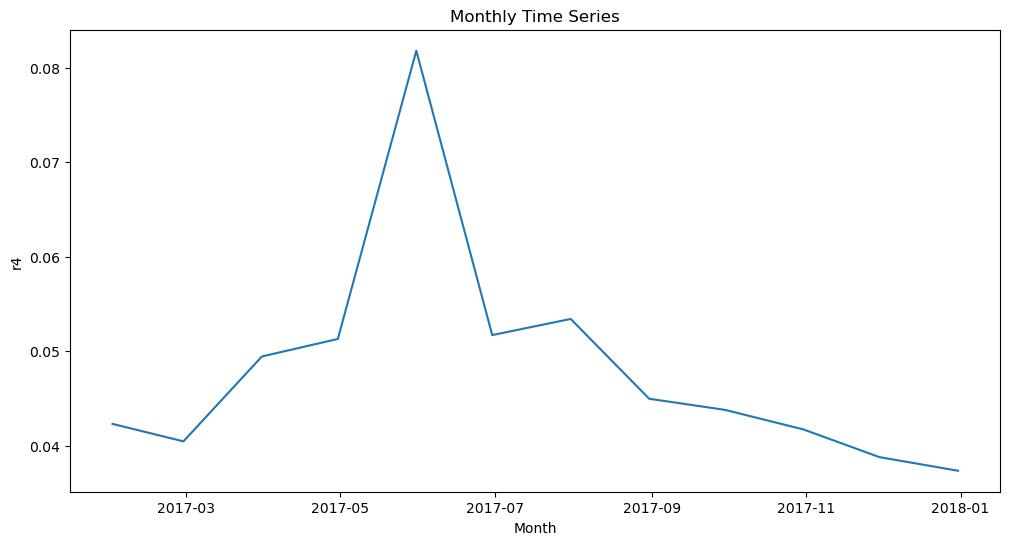

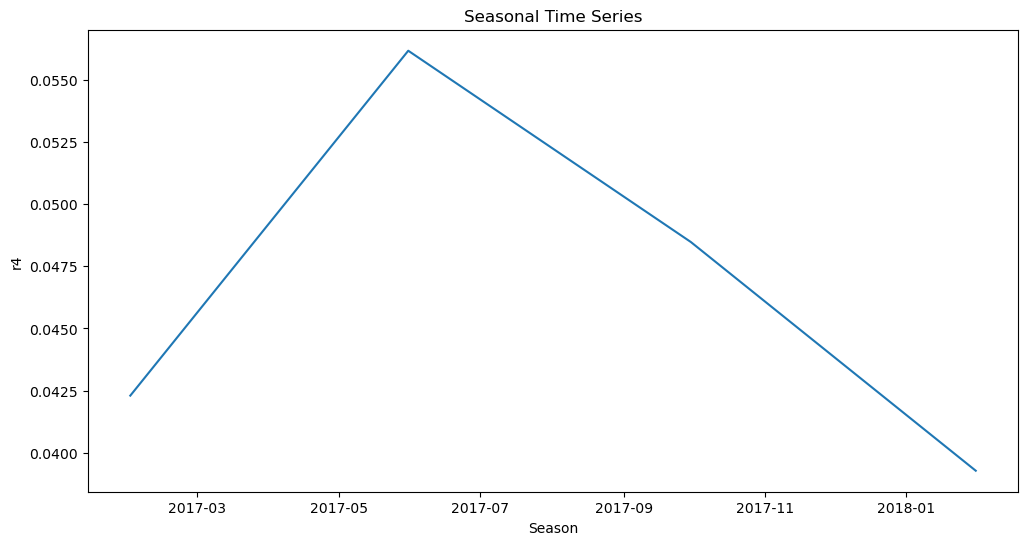

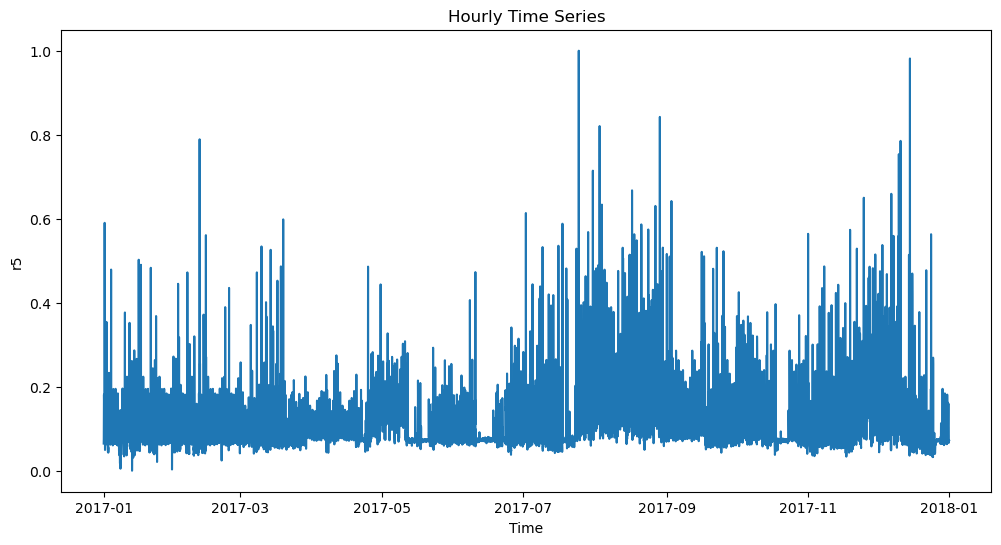

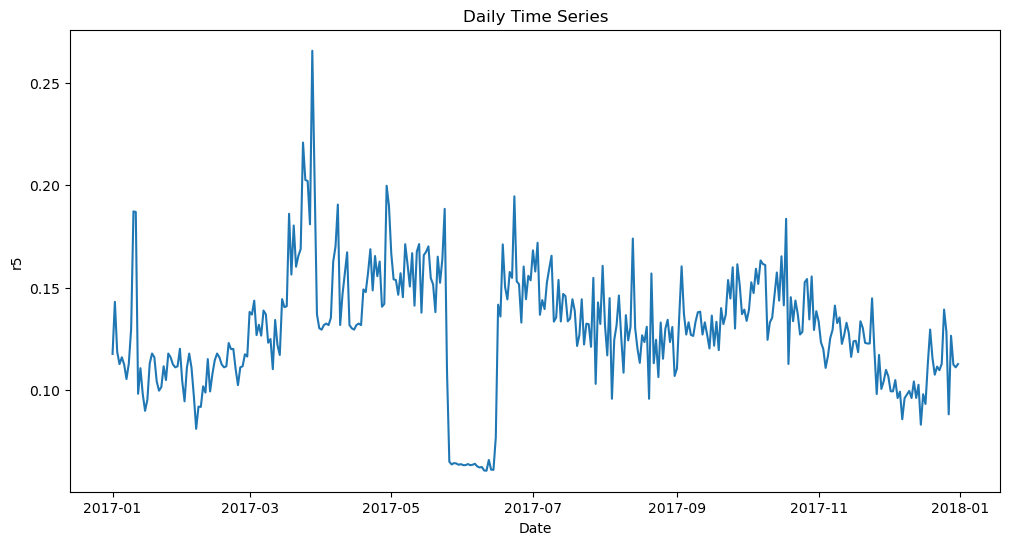

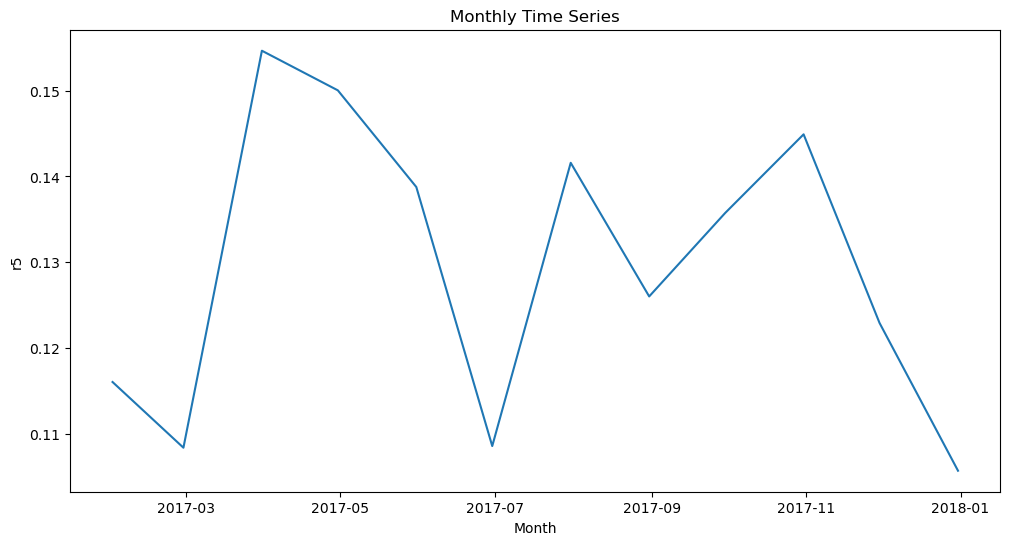

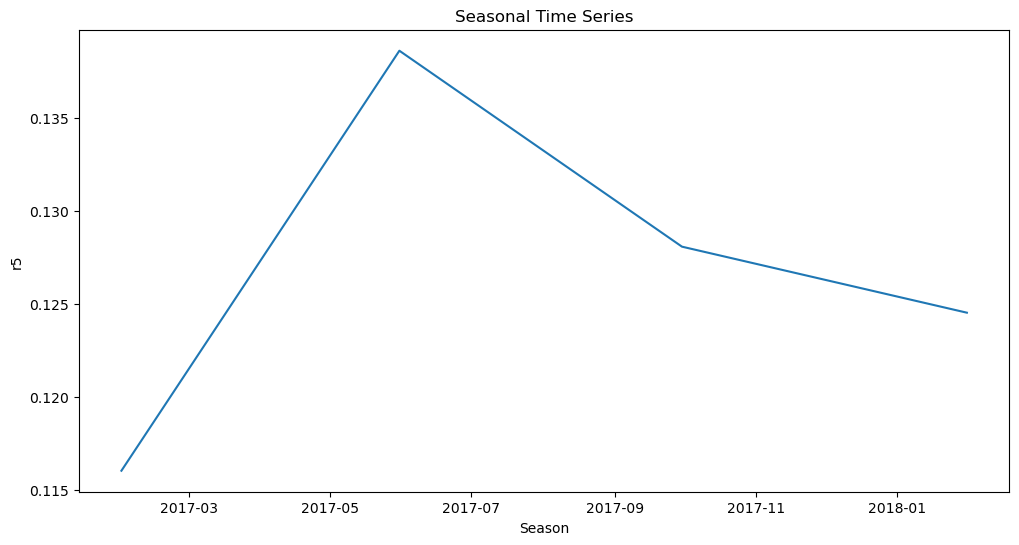

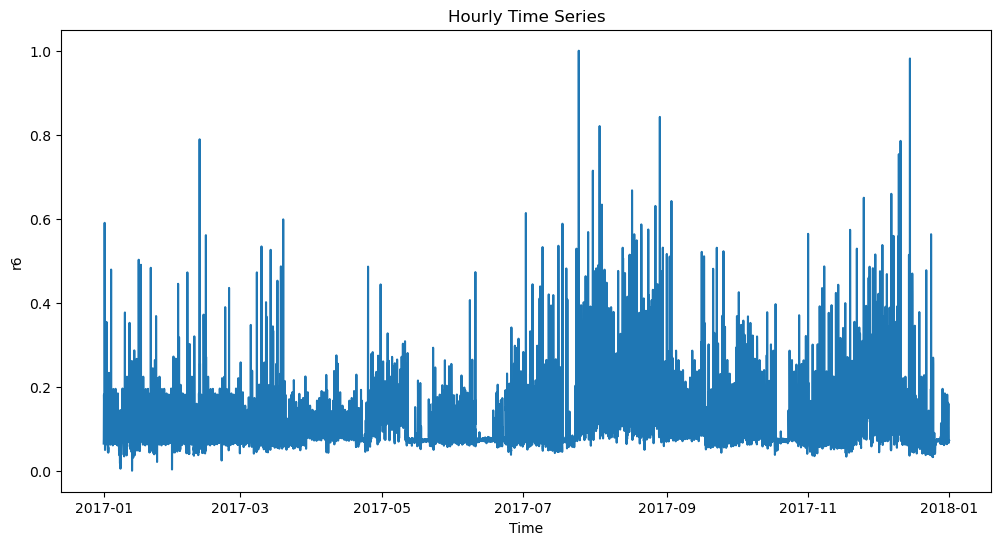

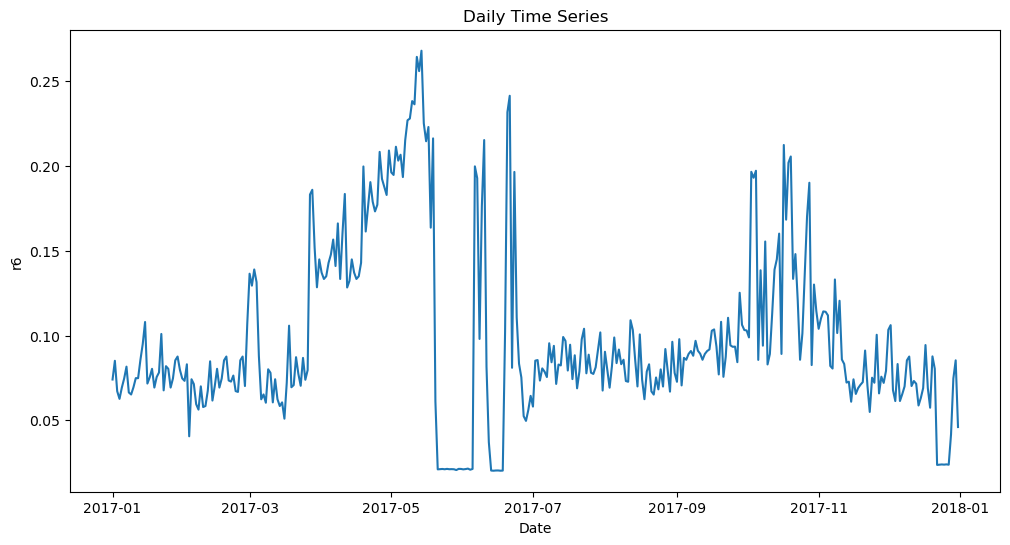

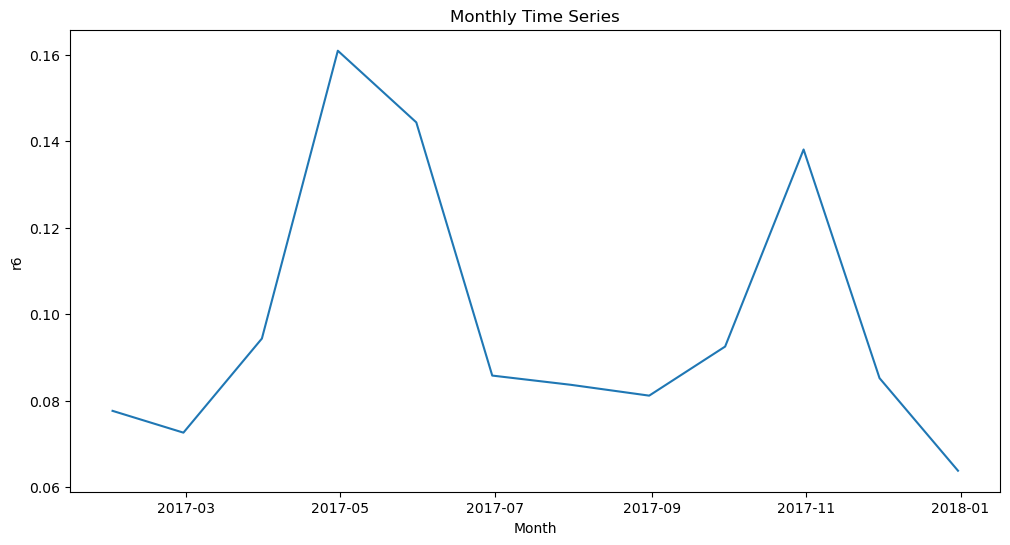

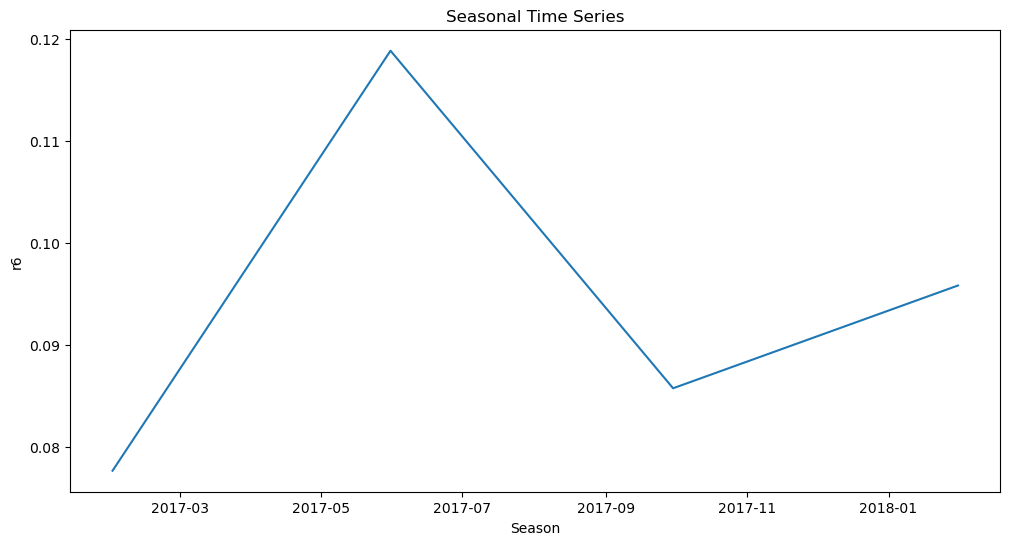

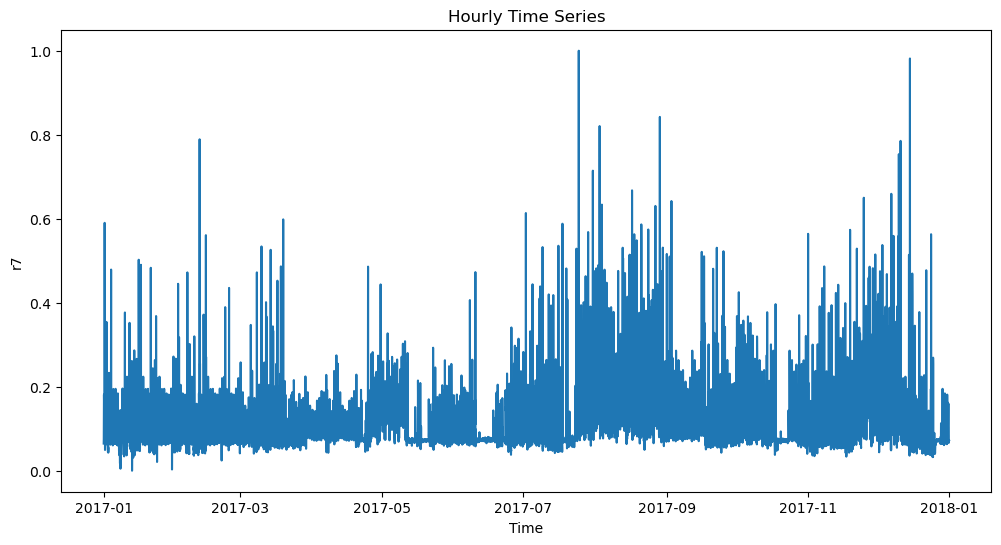

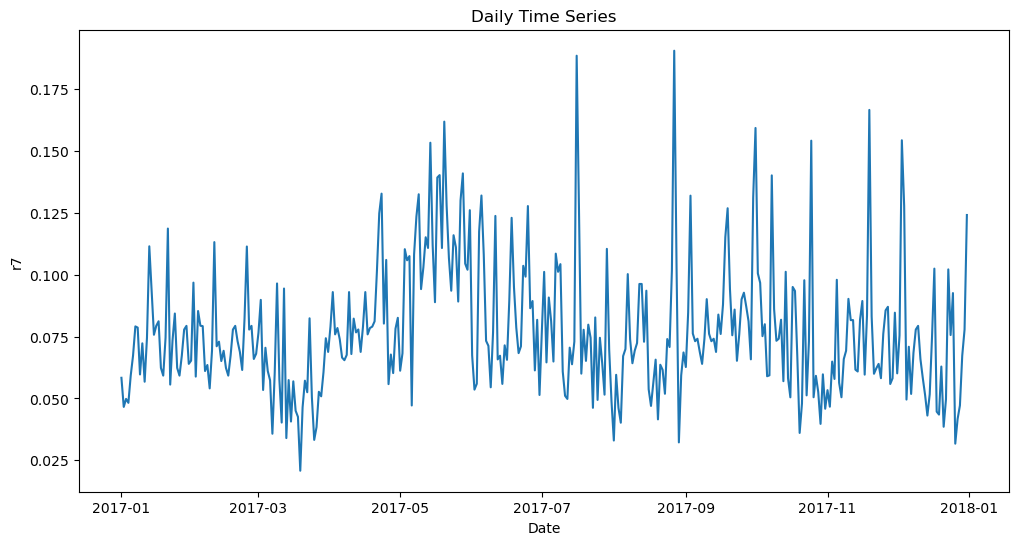

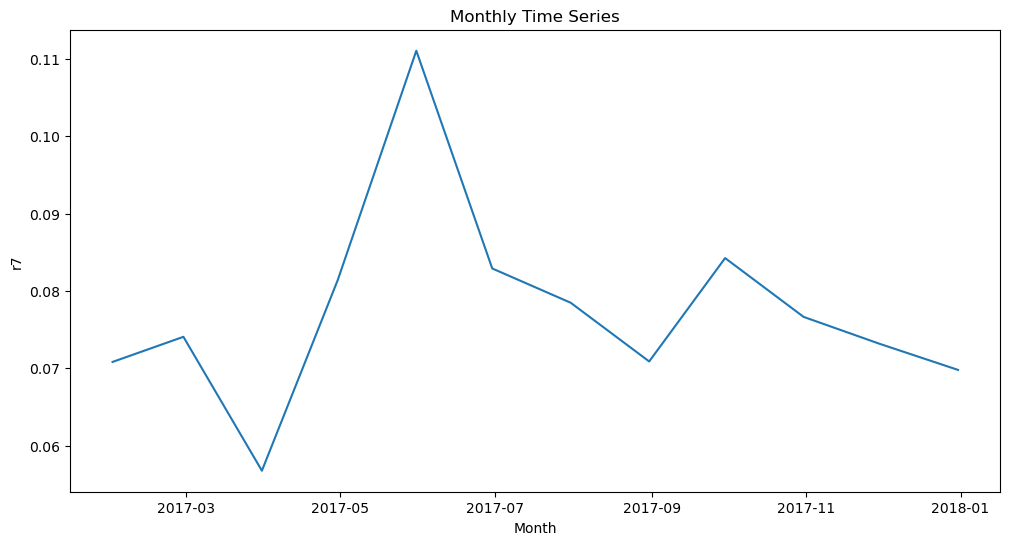

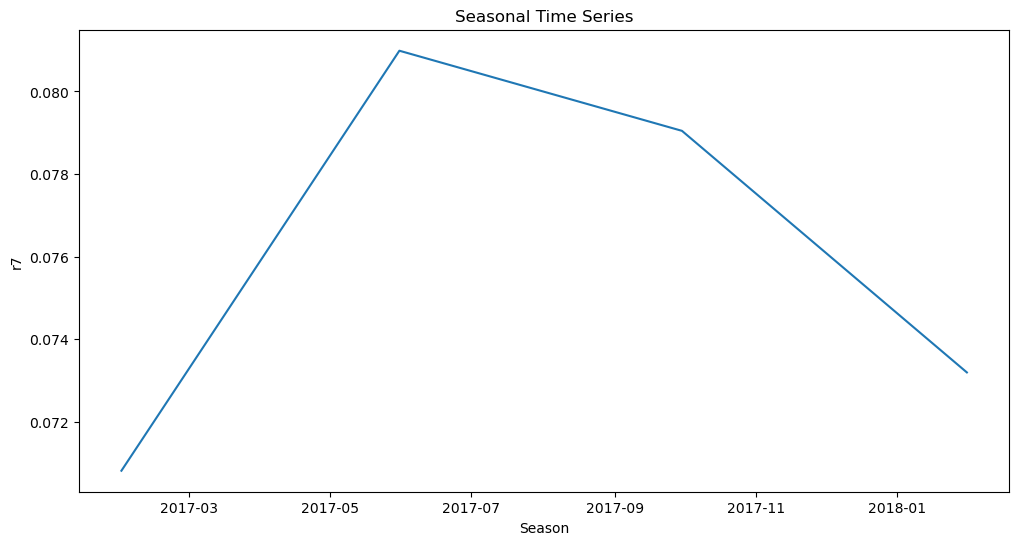

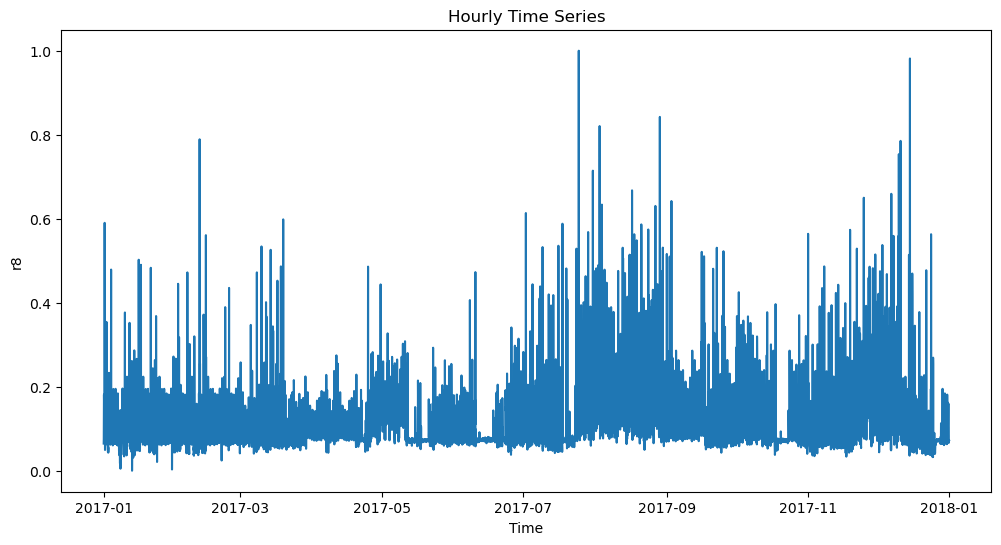

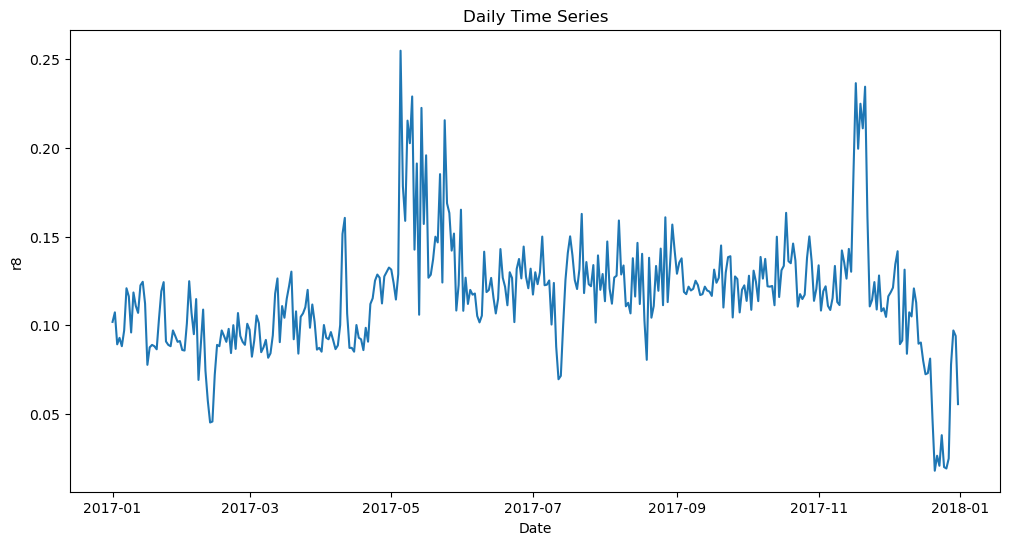

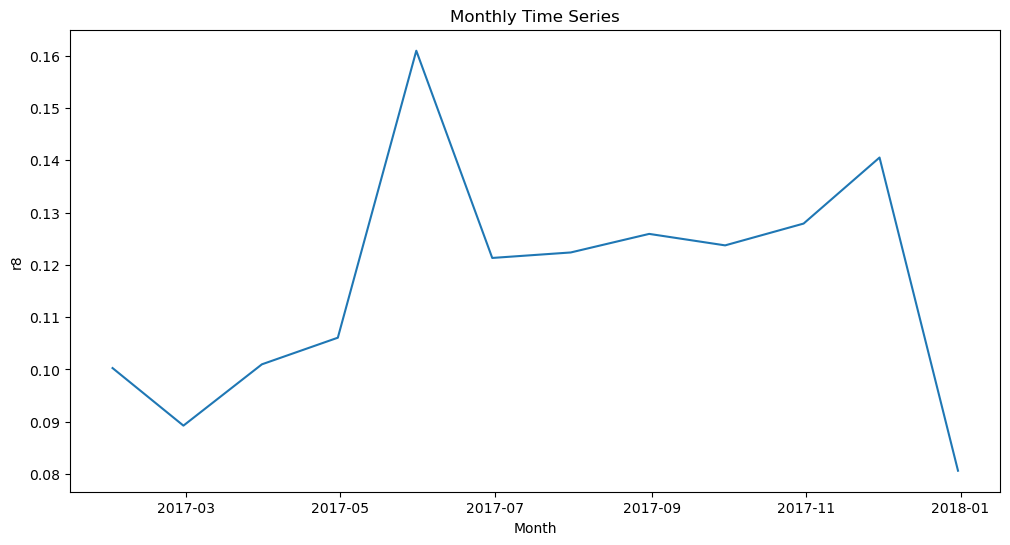

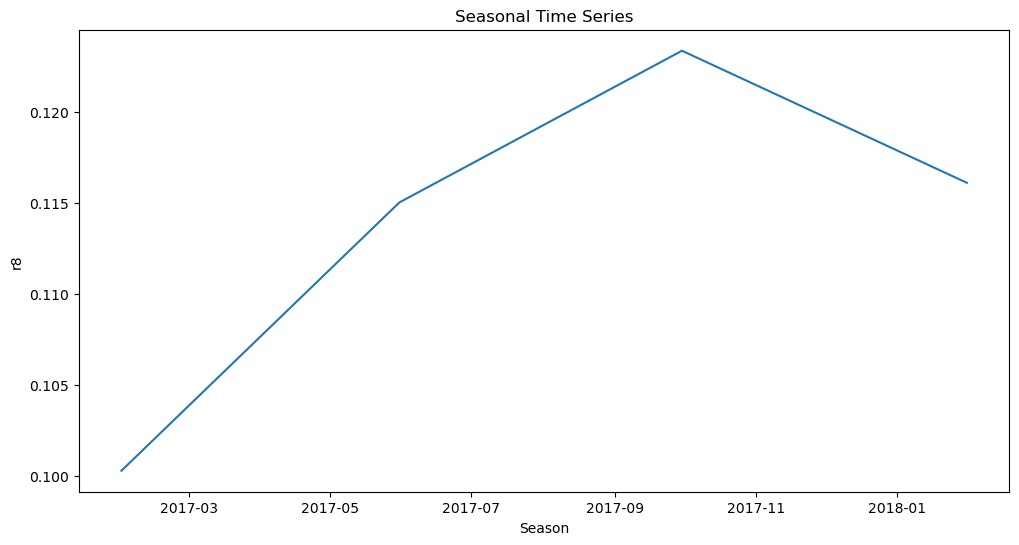

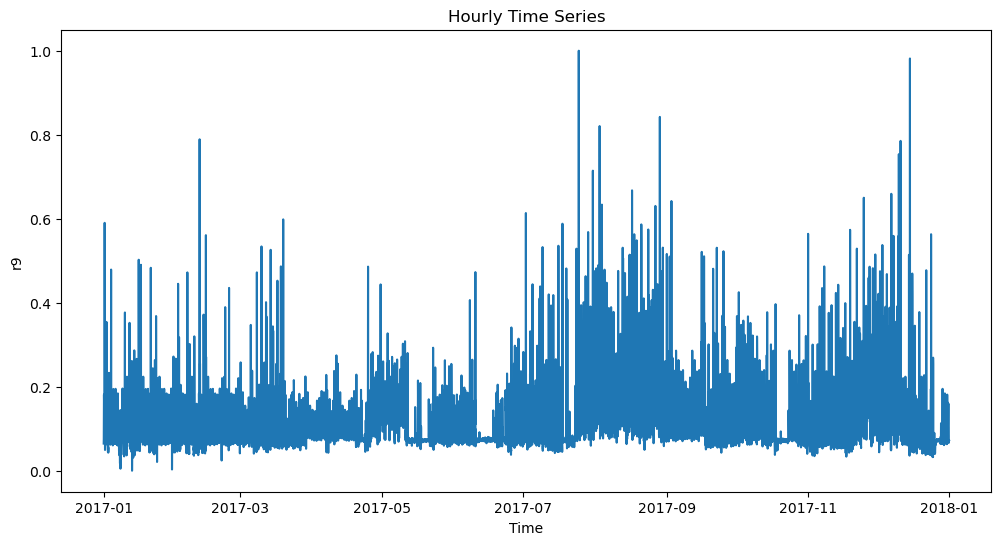

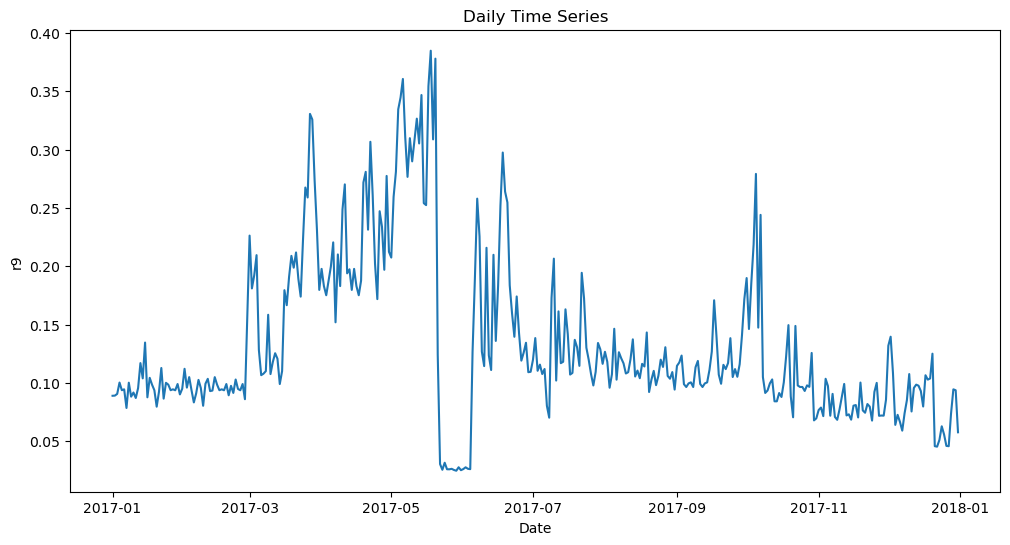

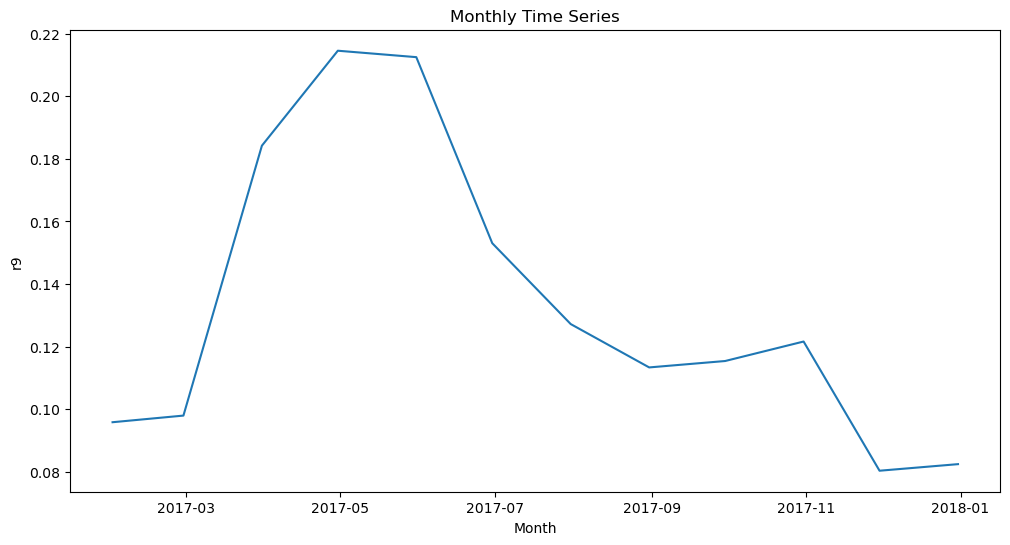

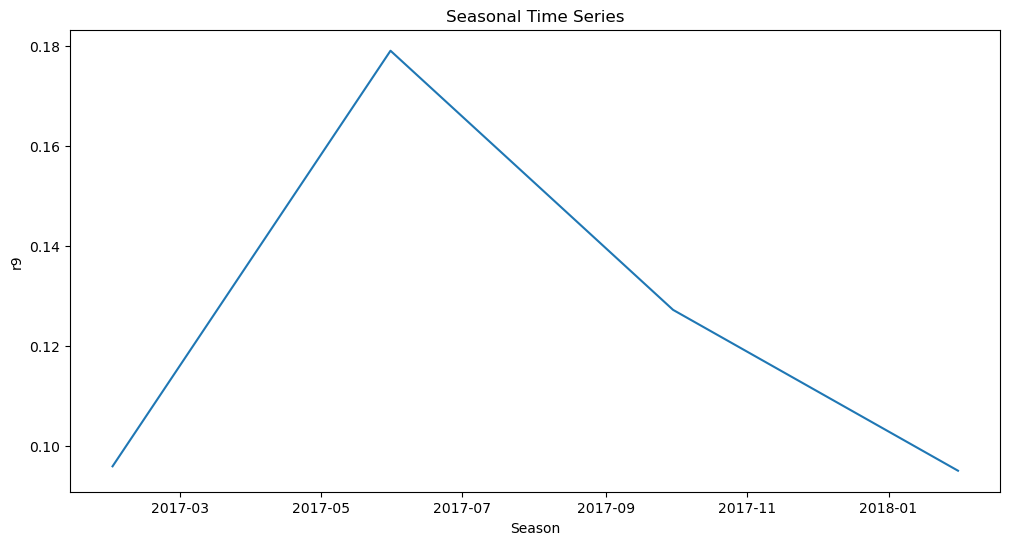

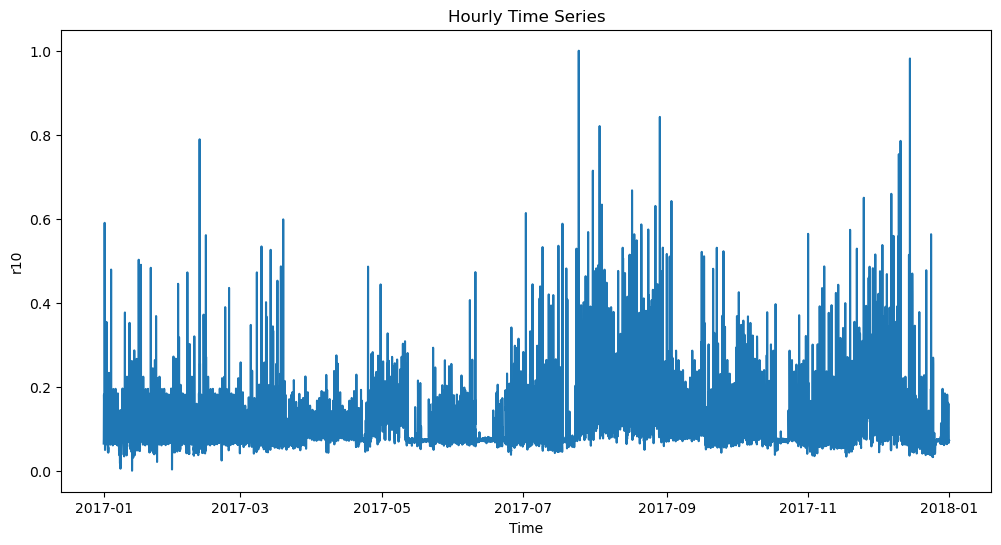

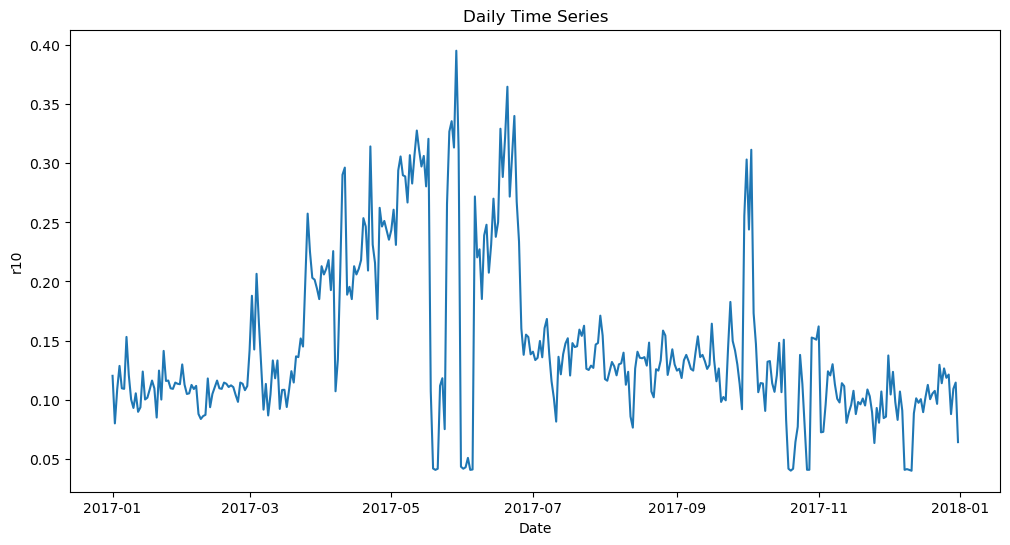

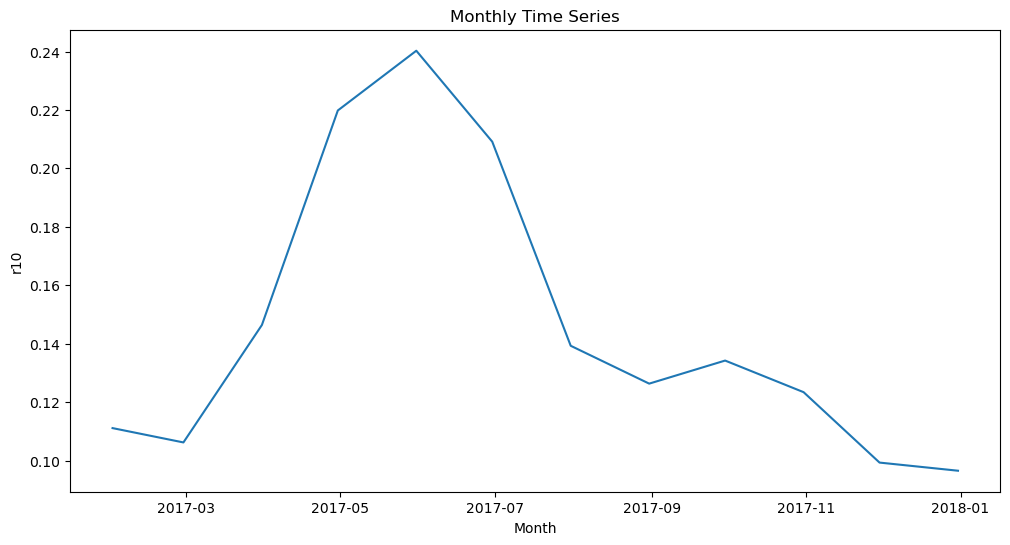

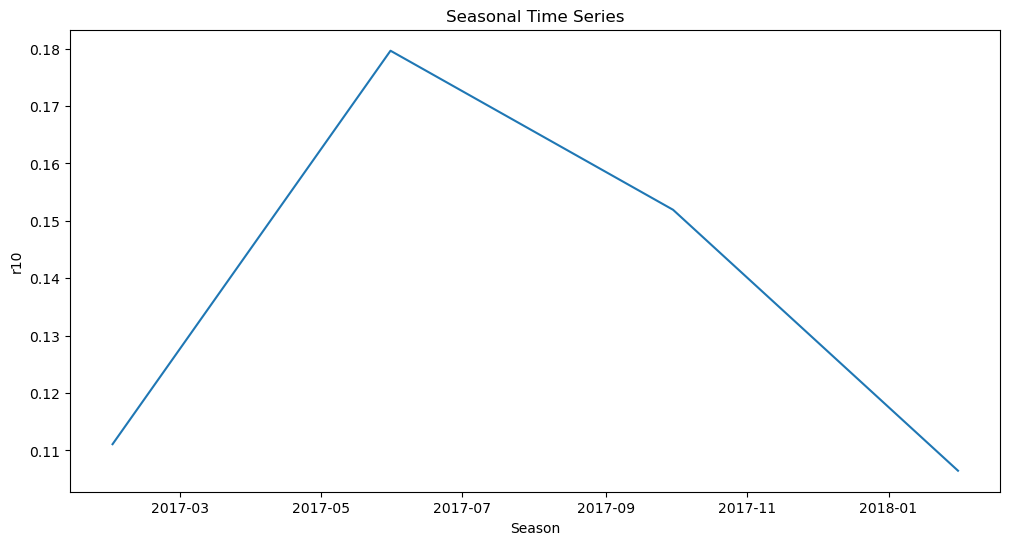

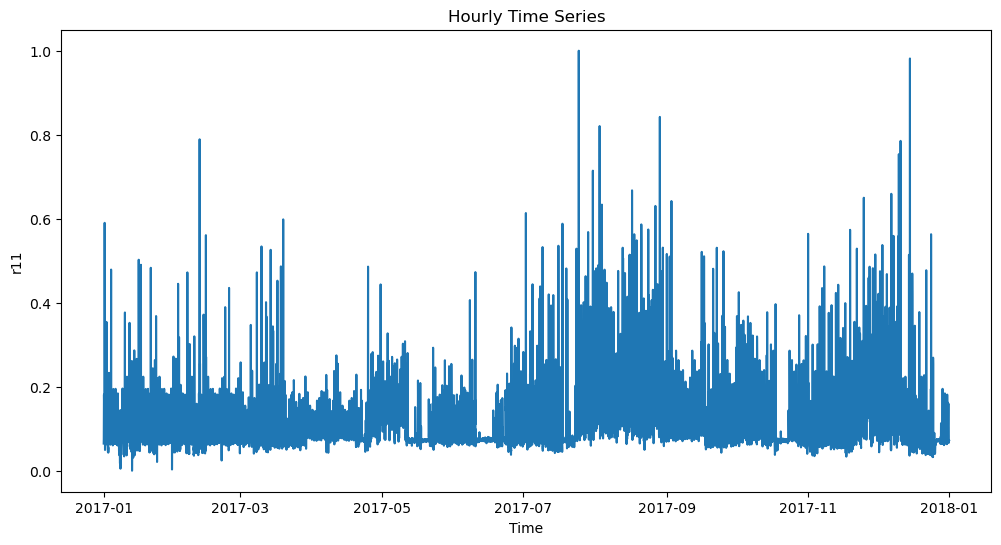

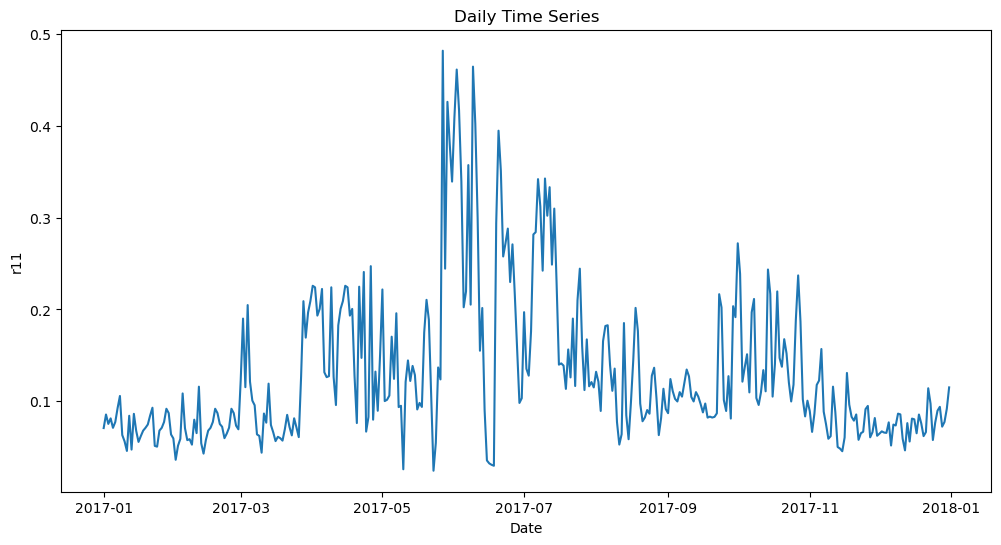

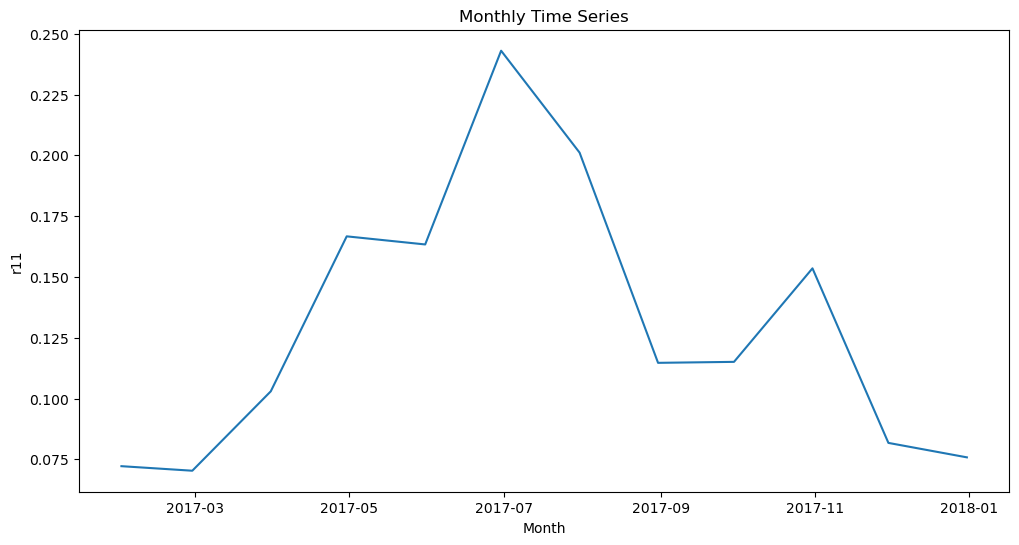

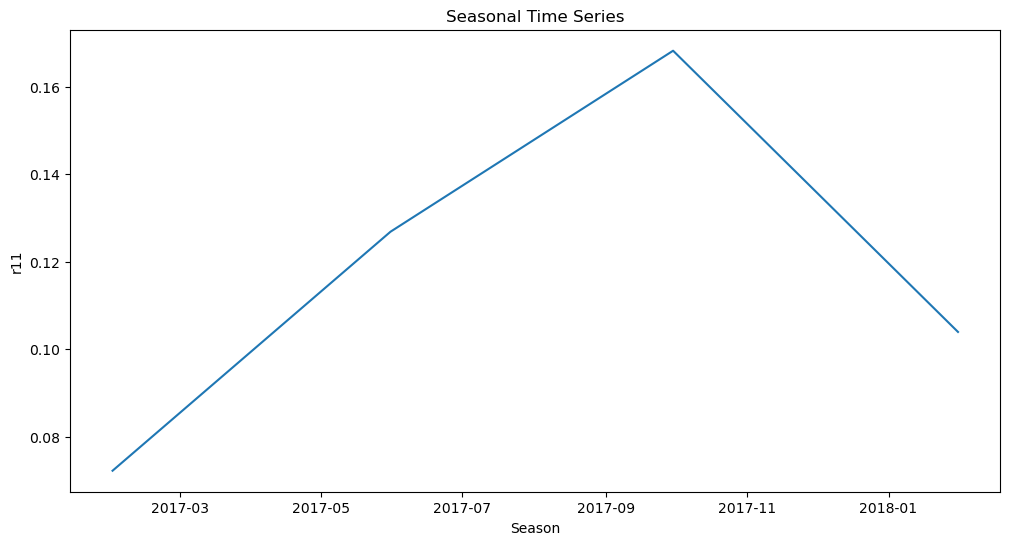

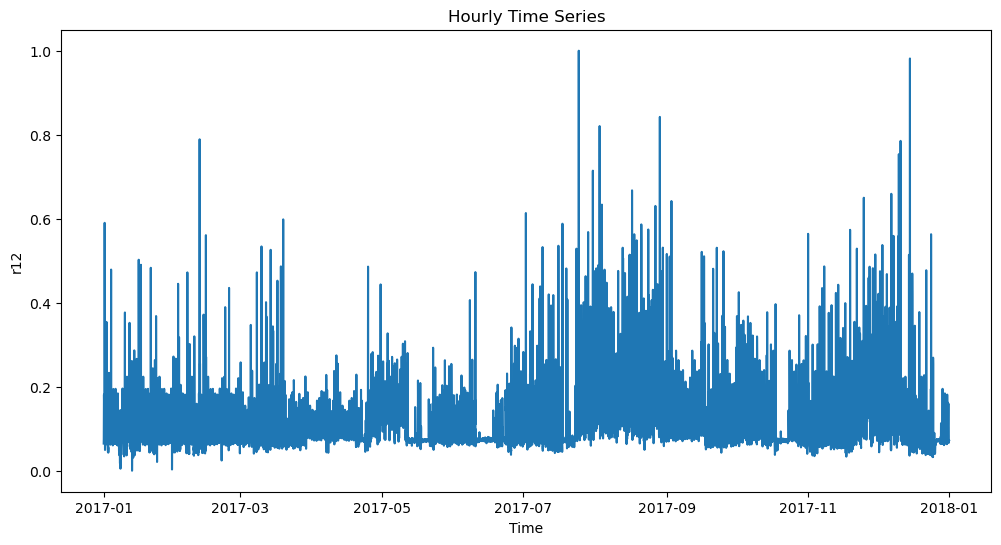

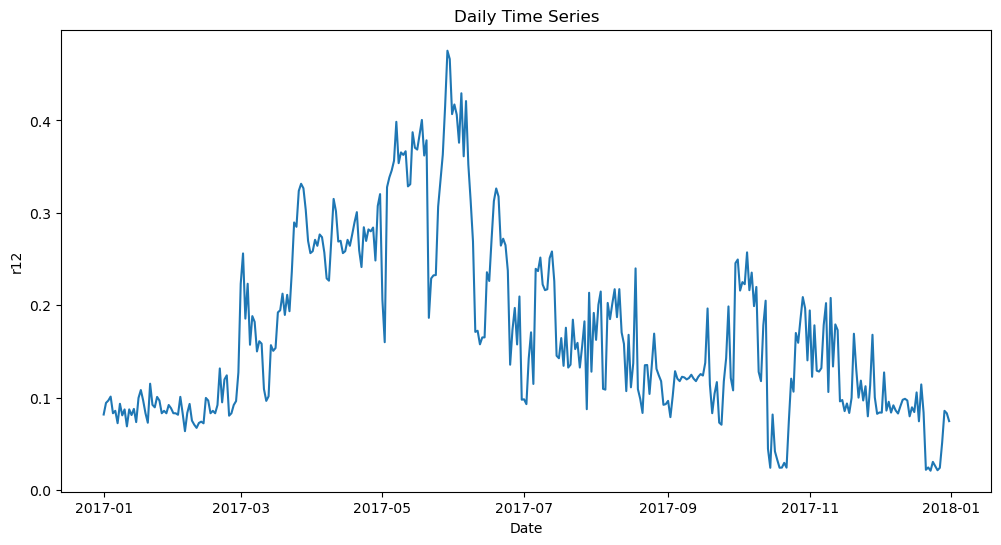

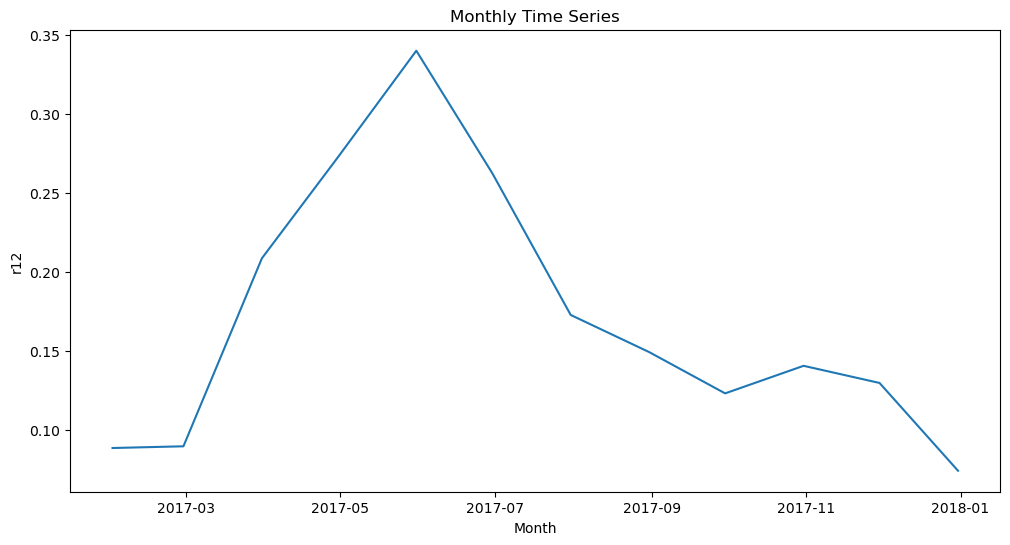

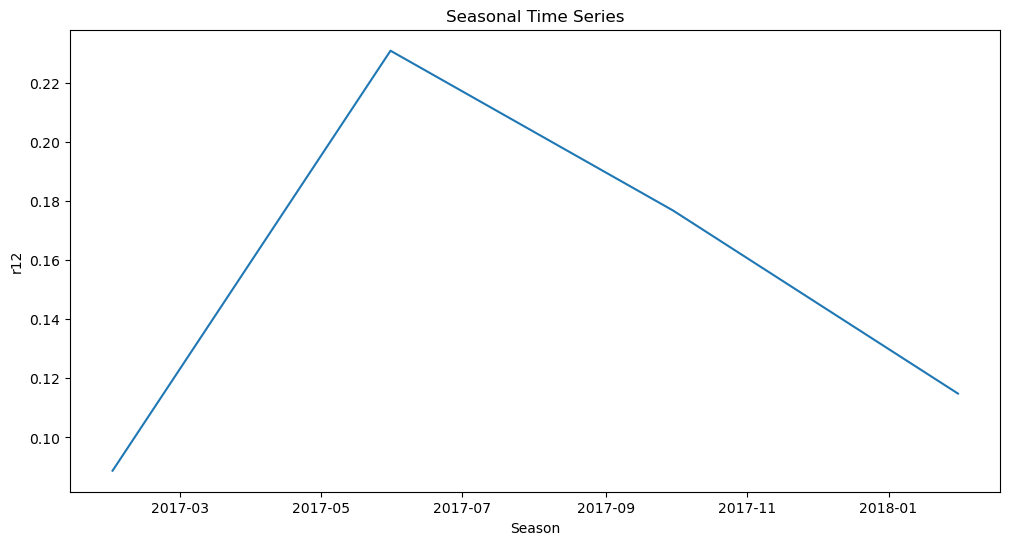

In [26]:
for i in range(1,13):
 

 #Resampling of data on hourly basis

 plt.figure(figsize=(12, 6))
 plt.plot(df_hourly.index, df_hourly['r1'])
 plt.xlabel('Time')
 plt.ylabel('r'+str(i))
 plt.title('Hourly Time Series')
 plt.show()
    
 
 #Resampling of data on daily basis
 plt.figure(figsize=(12, 6))
 plt.plot(df_daily.index, df_daily['r'+str(i)])
 plt.xlabel('Date')
 plt.ylabel('r'+str(i))
 plt.title('Daily Time Series')
 plt.show()
    
 #Resampling od data on montlhly basis   

 plt.figure(figsize=(12, 6))
 plt.plot(df_monthly.index, df_monthly['r'+str(i)])
 plt.xlabel('Month')
 plt.ylabel('r'+str(i))
 plt.title('Monthly Time Series')
 plt.show()

 #Resampling of data on seasonal basis

 plt.figure(figsize=(12, 6))
 plt.plot(df_seasonal.index, df_seasonal['r'+str(i)])
 plt.xlabel('Season')
 plt.ylabel('r'+str(i))
 plt.title('Seasonal Time Series')
 plt.show()


 

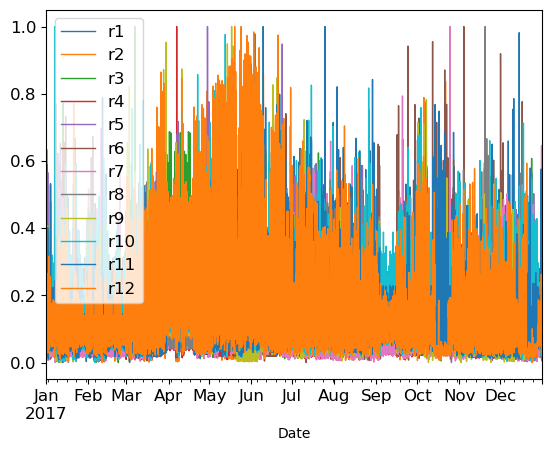

In [27]:
#plot_timeseries data
ax = df_r.plot(linewidth=1, fontsize=12)
ax.set_xlabel('Date')
ax.legend(fontsize=12)


In [28]:
min_new = 0.001
df_r1 = df_r * (1 - min_new) + min_new
#as seasonal decompose doesnt take values in zero

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\2337924241.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


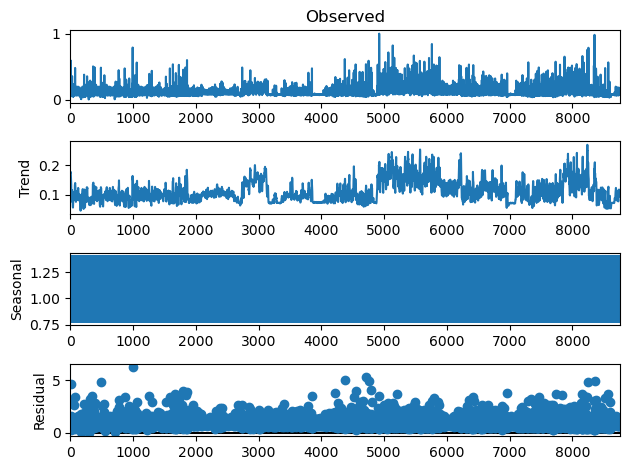

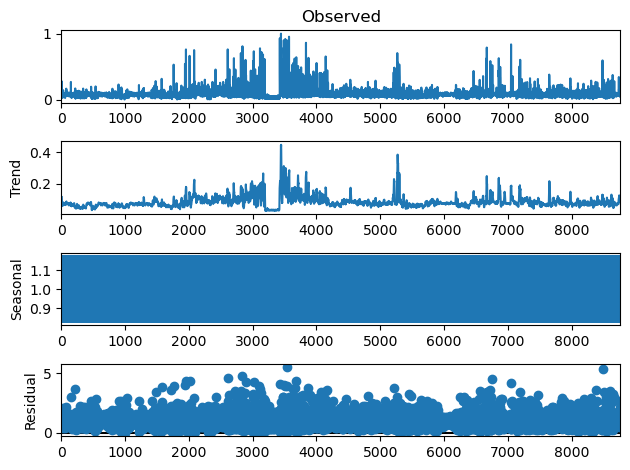

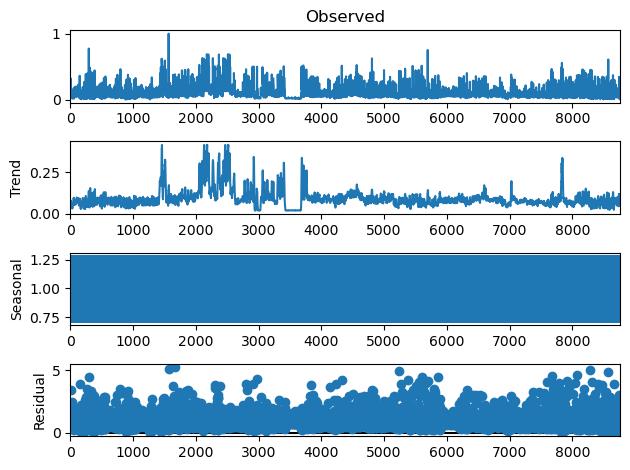

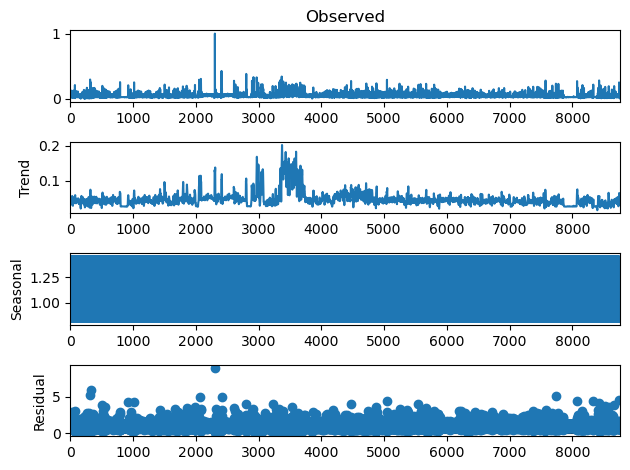

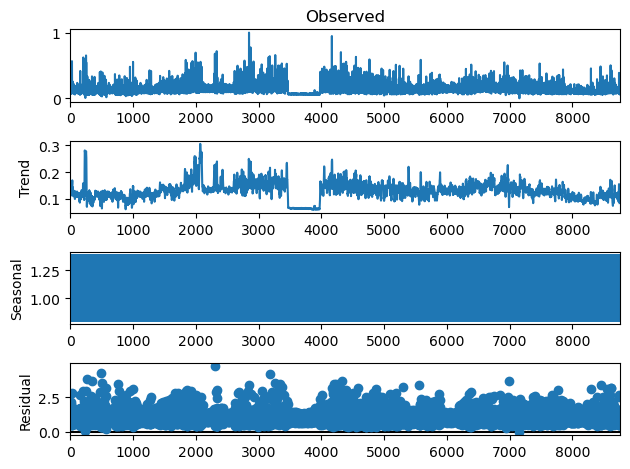

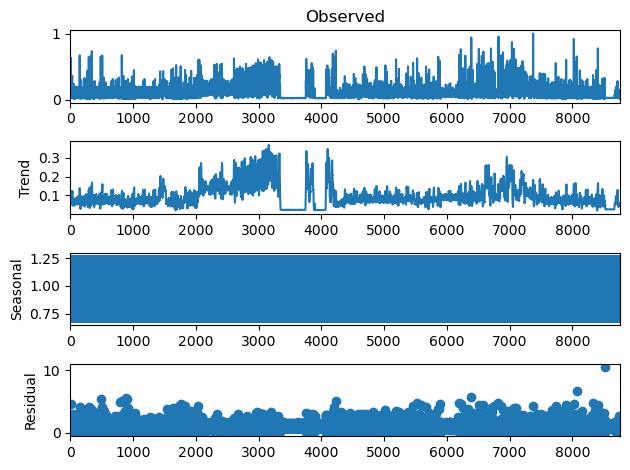

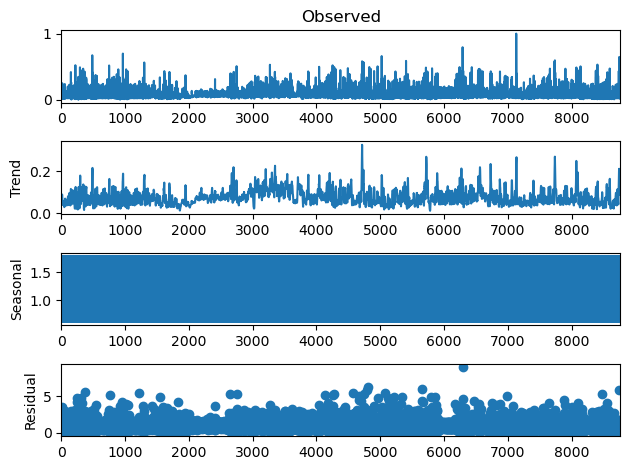

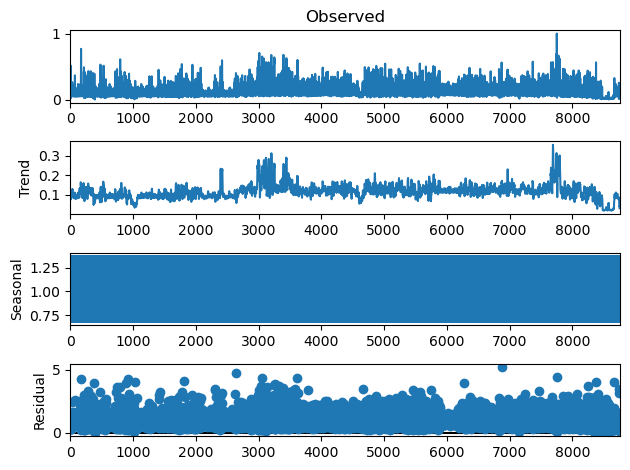

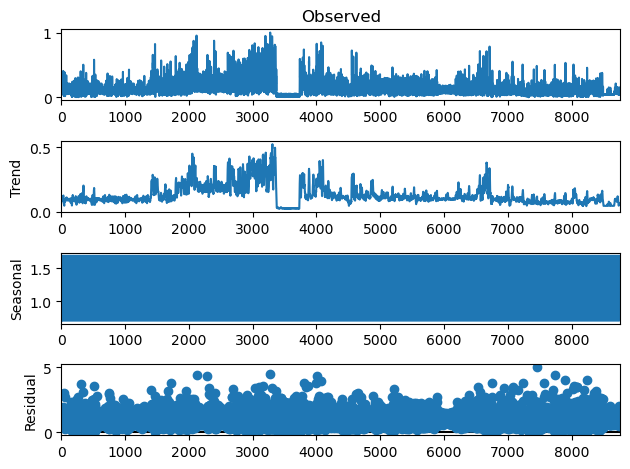

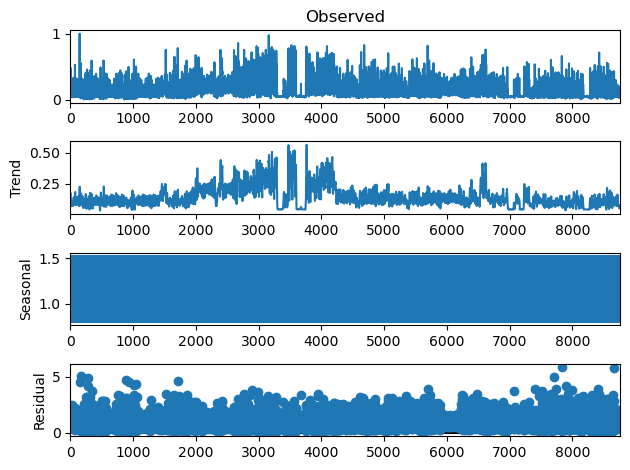

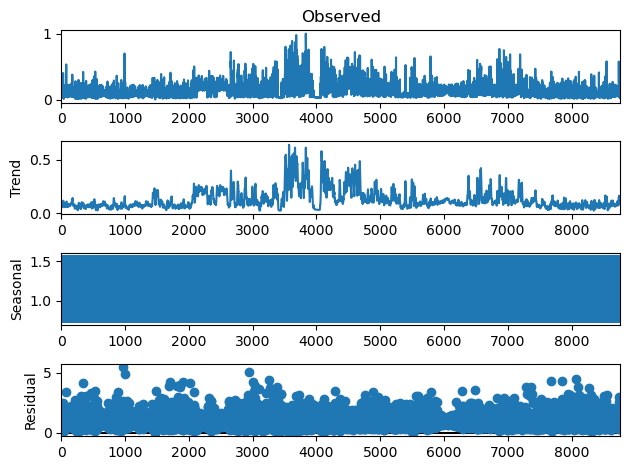

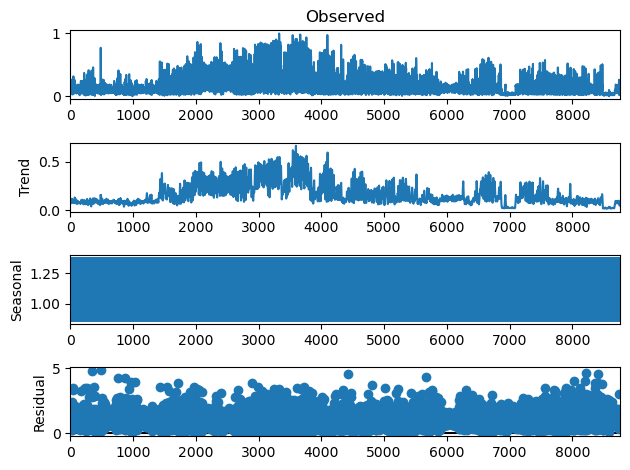

In [29]:
for i in df_r.columns:
    res = sm.tsa.seasonal_decompose(df_r1[i].values,period=12,model="multiplicative")
    #plt.figure(figsize=(16,12))
    fig = res.plot()
    fig.show()




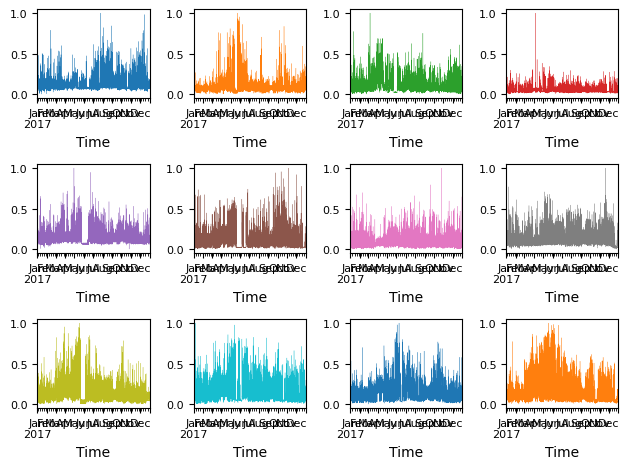

In [30]:
#To visualize the data side-by-side r1 to r12
df_hourly.plot(subplots=True,
          layout=(3, 4),
          sharex=False,
          sharey=False,
         fontsize=8,
         legend=False,
         linewidth=0.2)
plt.tight_layout()

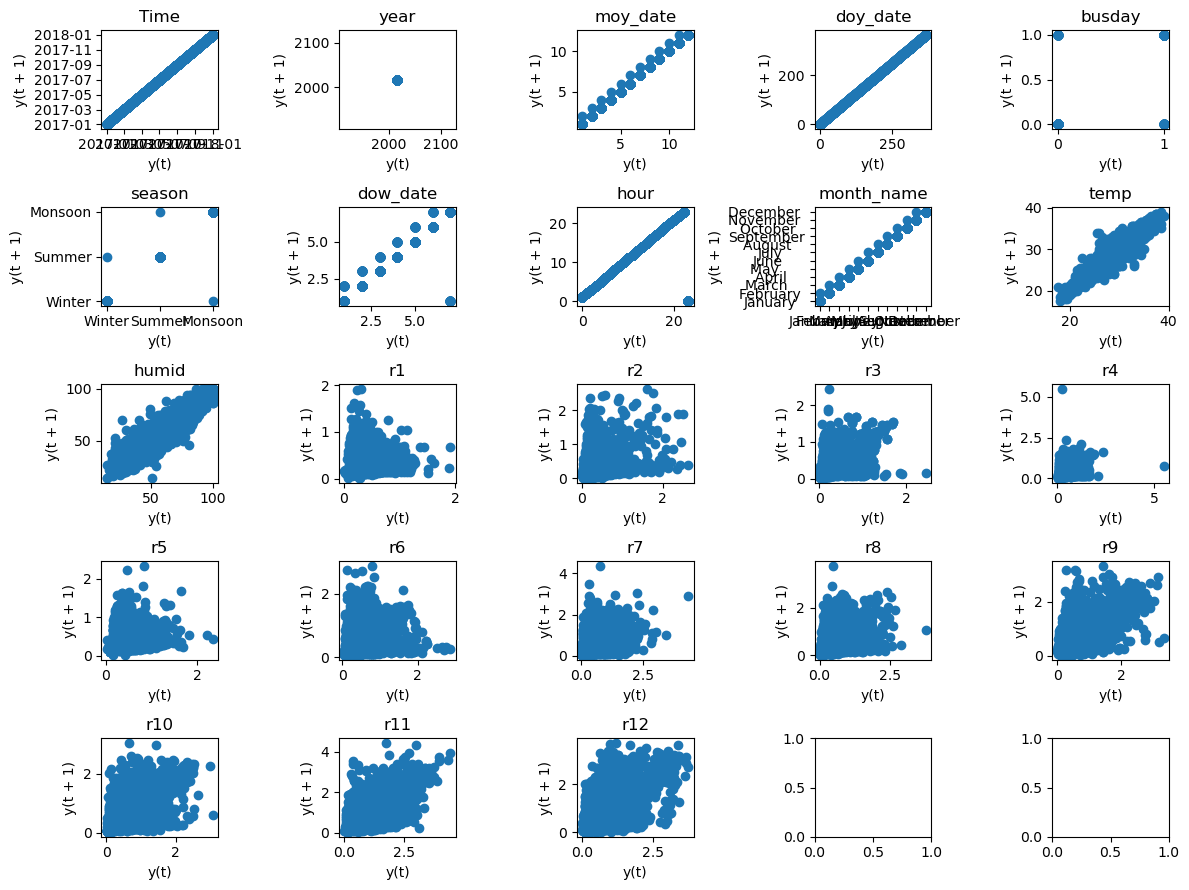

In [31]:
col = df.columns
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 9)) 
for i, column in enumerate(col):
    row = i // 5  
    col = i % 5  

    ax = axes[row, col]  

    pd.plotting.lag_plot(df[column], ax=ax)
    ax.set_title(column) 

plt.tight_layout() 
plt.show()


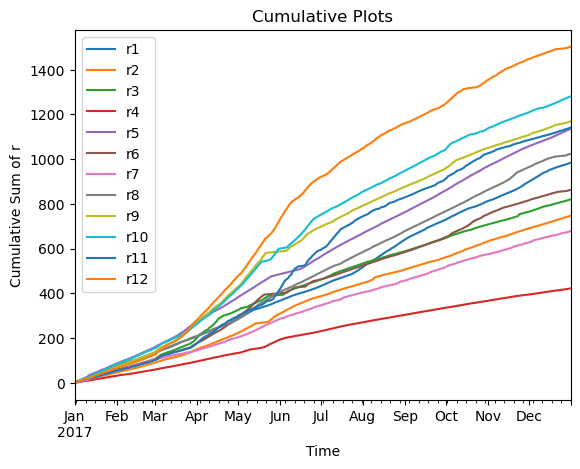

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

for i in df_r.columns:
    df_r[i].cumsum().plot(label=i)

plt.xlabel('Time')
plt.ylabel('Cumulative Sum of r')
plt.title('Cumulative Plots')

plt.legend()
plt.show()

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\3837702508.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x = df['Time'].dt.month, y = df['r1'], palette='viridis',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


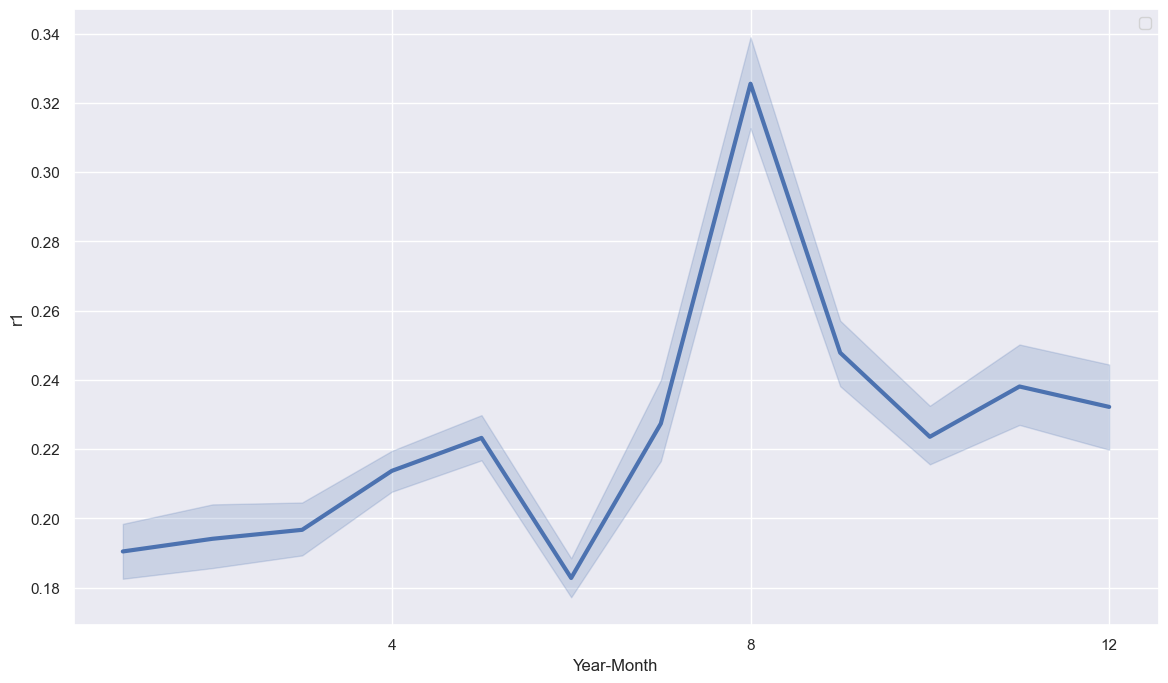

In [33]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df, x = df['Time'].dt.month, y = df['r1'], palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('r1')
plt.xlabel('Year-Month')
plt.show()

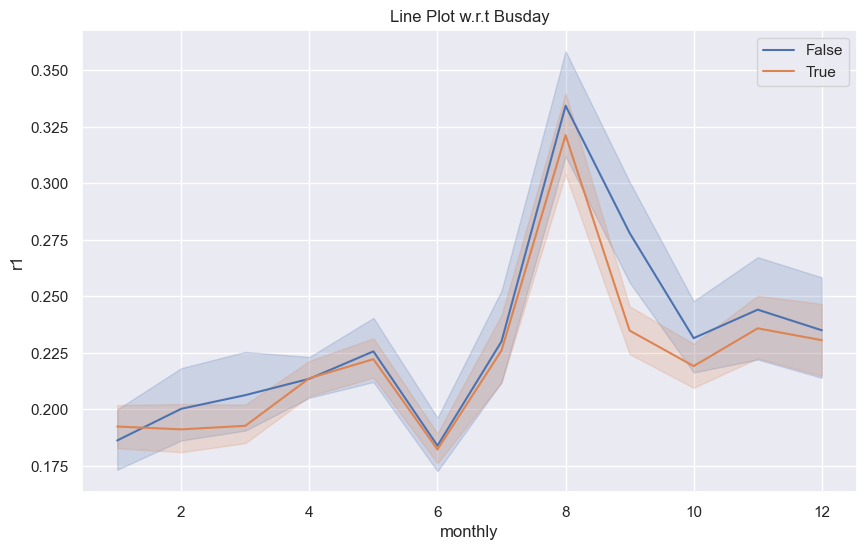

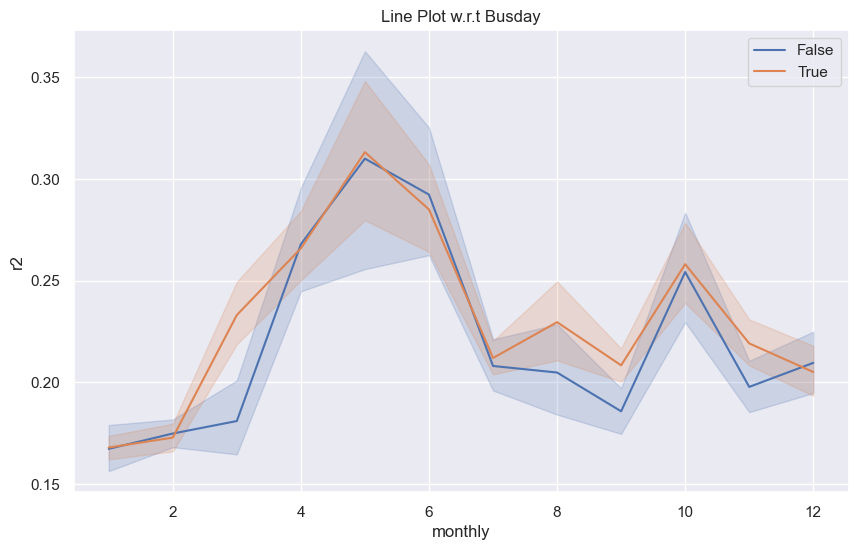

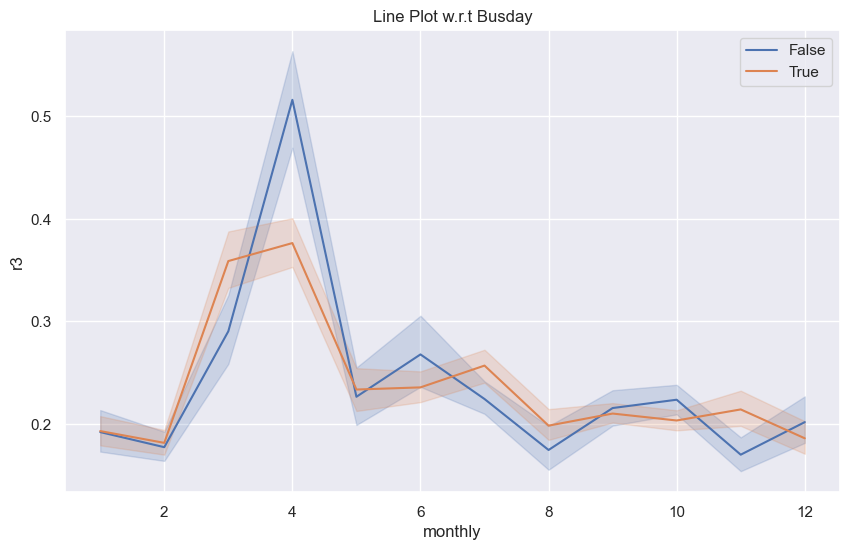

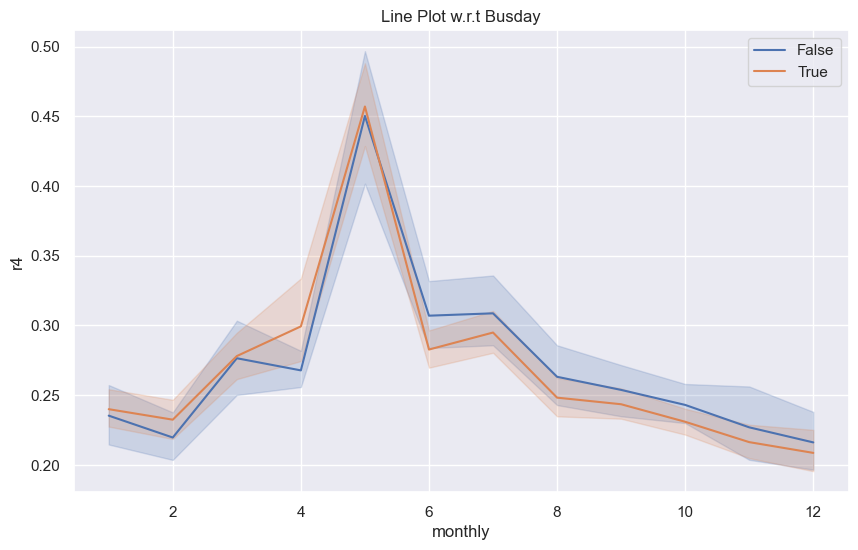

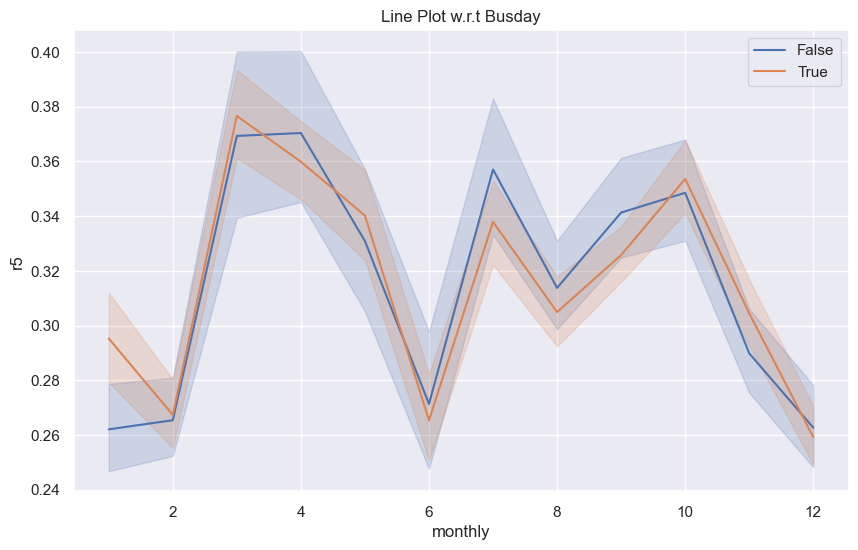

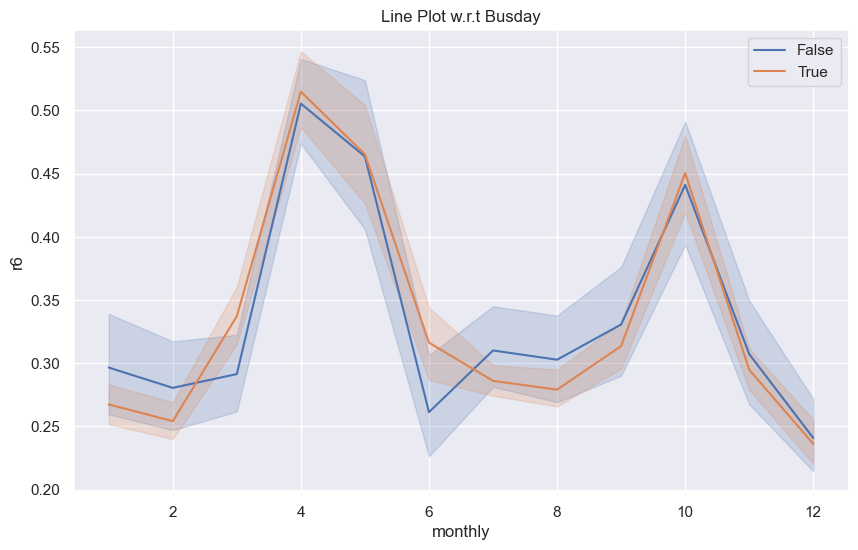

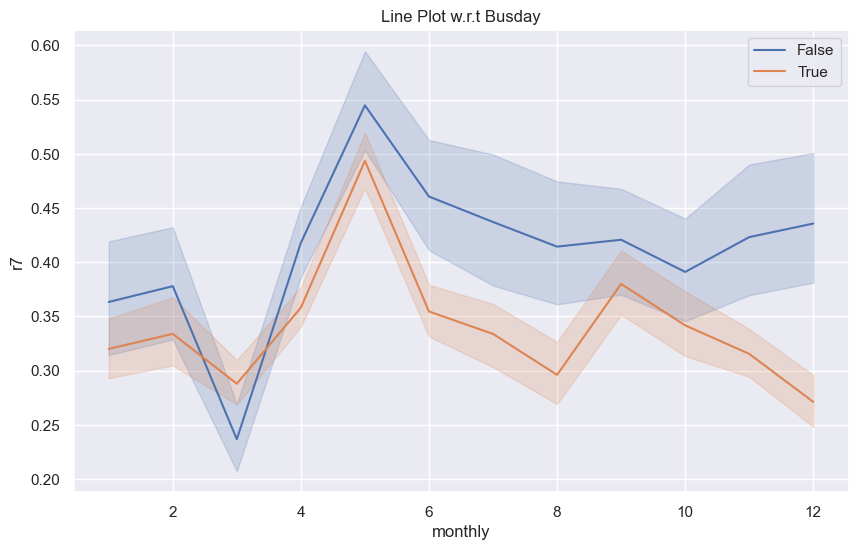

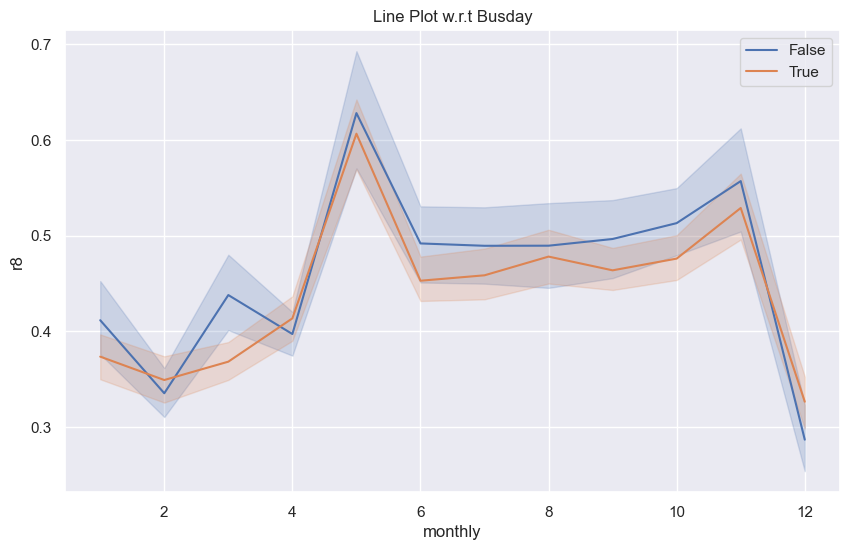

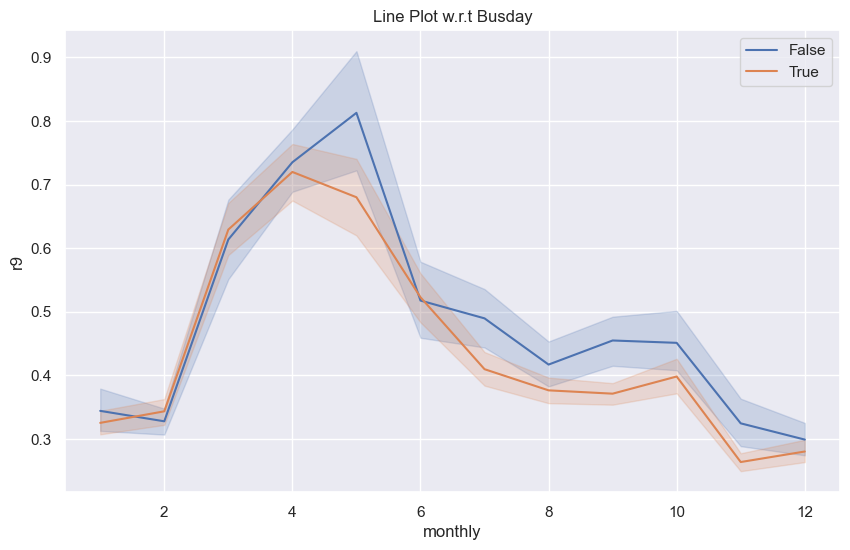

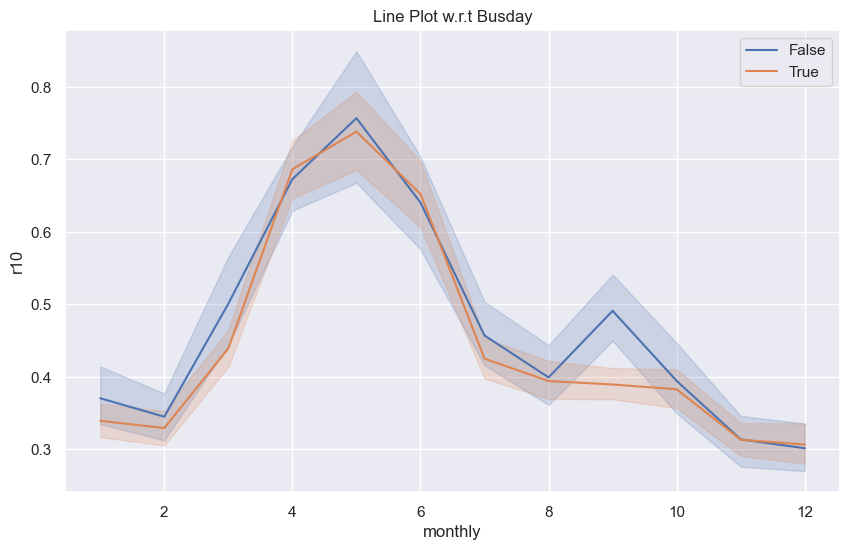

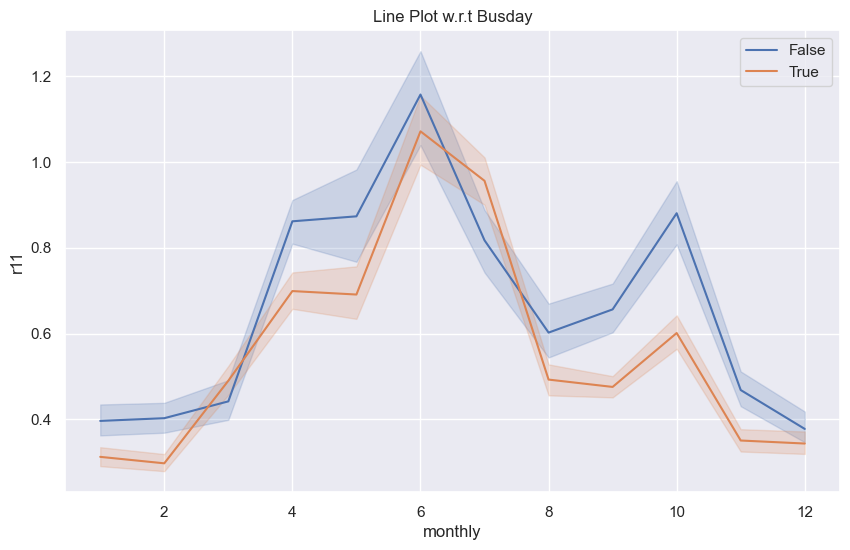

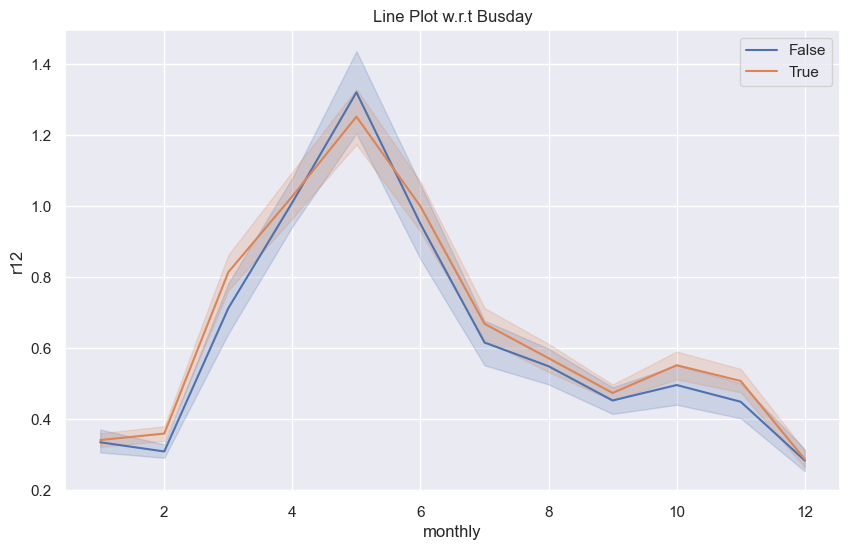

In [201]:
for i in range(1,13):
 sns.set_style('darkgrid')
 sns.set(rc={'figure.figsize': (10, 6)})

 # Create the line plot with multiple lines
 #sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r1'], label='Line 1')
 #sns.lineplot(data=df, x=df['Time'].dt.month, y= df['r1'], hue=df['season'], label='Line 2')
 sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r'+str(i)], hue=df['busday'], label='')

 plt.xlabel('monthly')
 plt.ylabel('r'+str(i))
 plt.title('Line Plot w.r.t Busday')

 plt.legend()
 plt.show()

In [35]:
category_mapping = {'Winter': 0, 'Summer': 1, 'Monsoon': 2}
df['Season'] = df['season']
df['Season'] = pd.factorize(df['season'])[0]
df['Season'] = df['Season'].replace(category_mapping)
#df['Season'][5000]


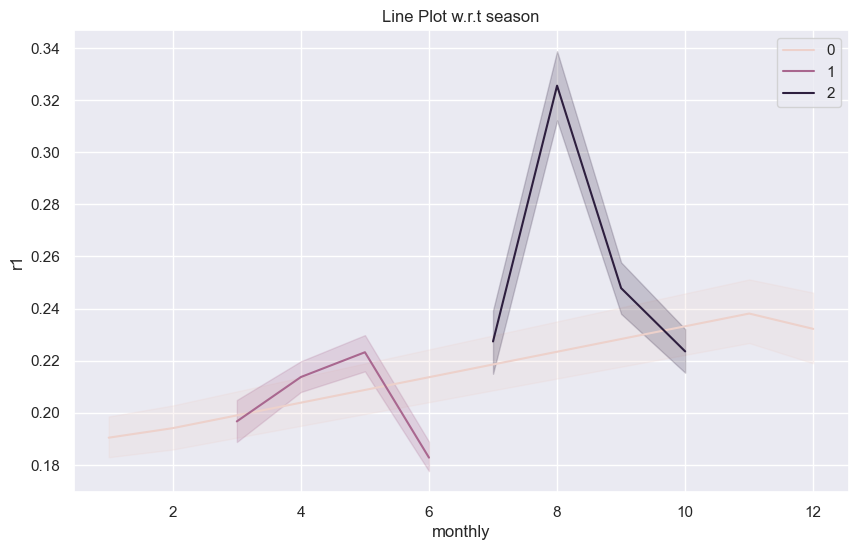

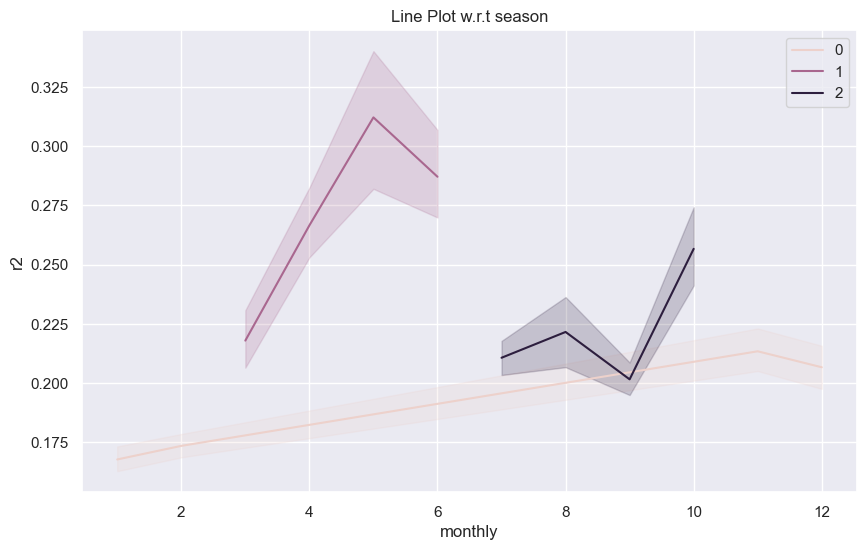

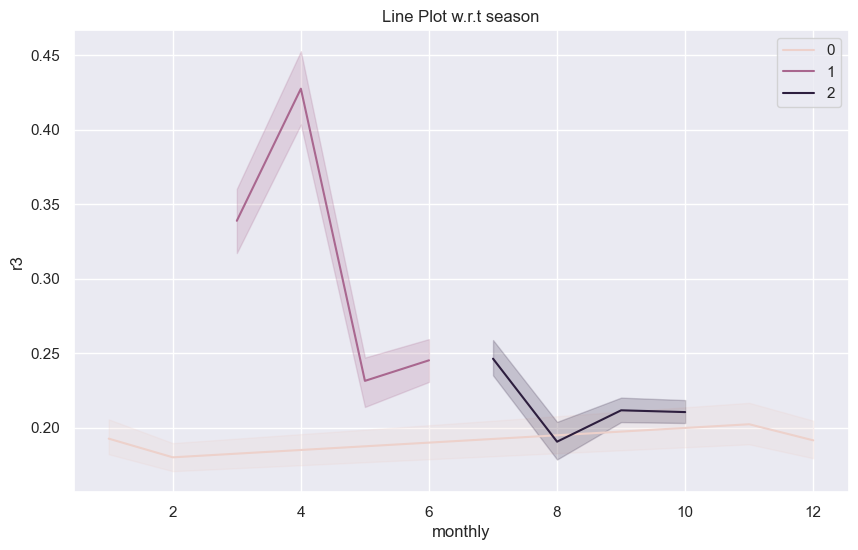

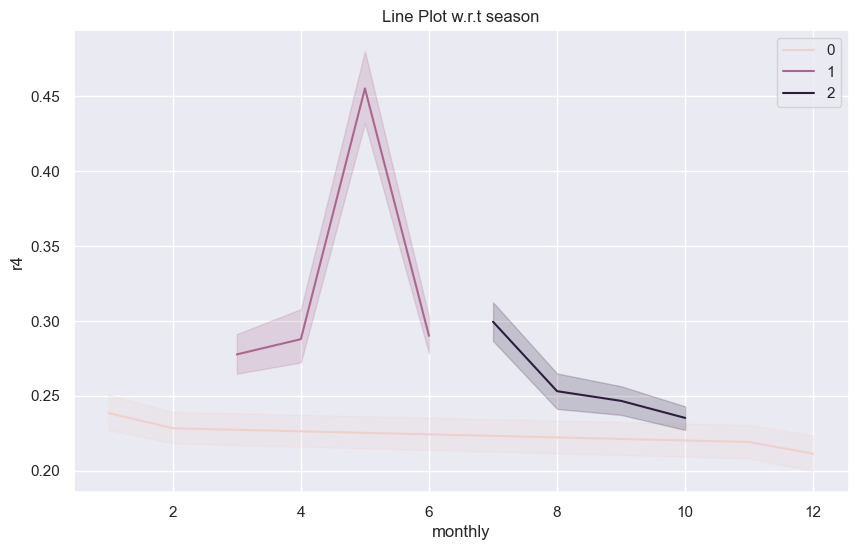

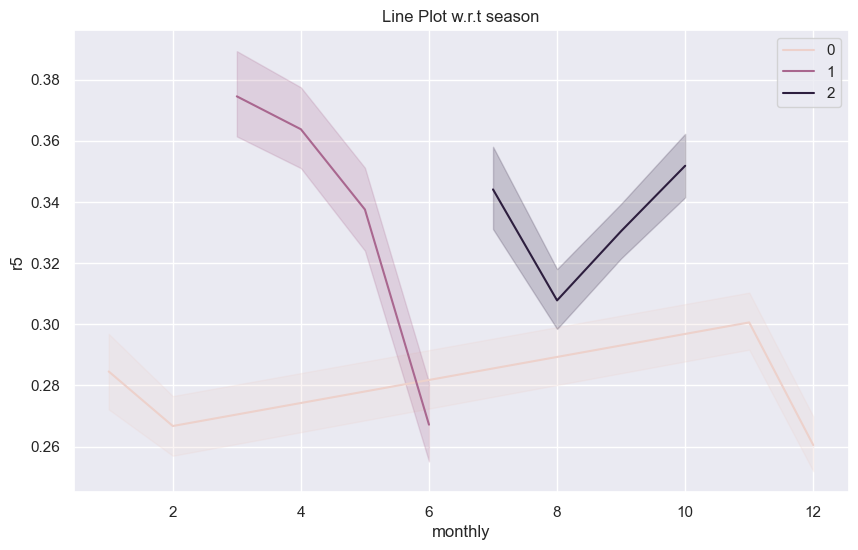

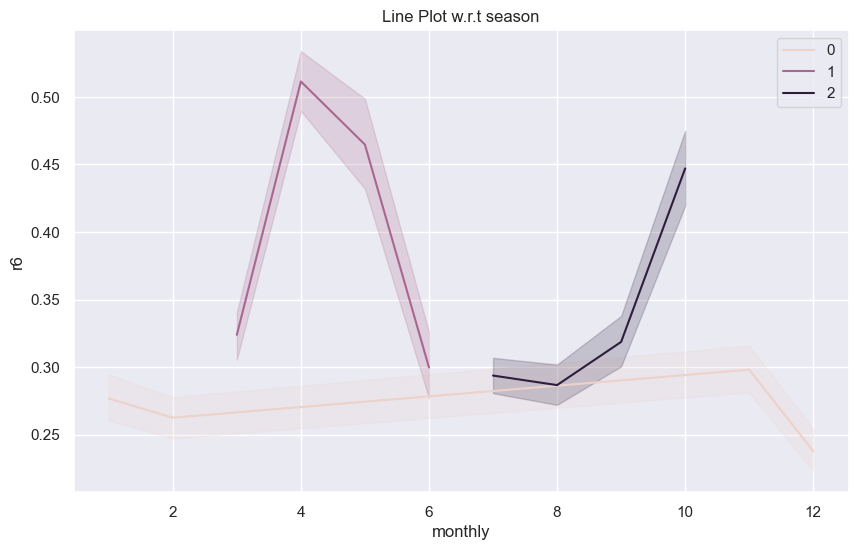

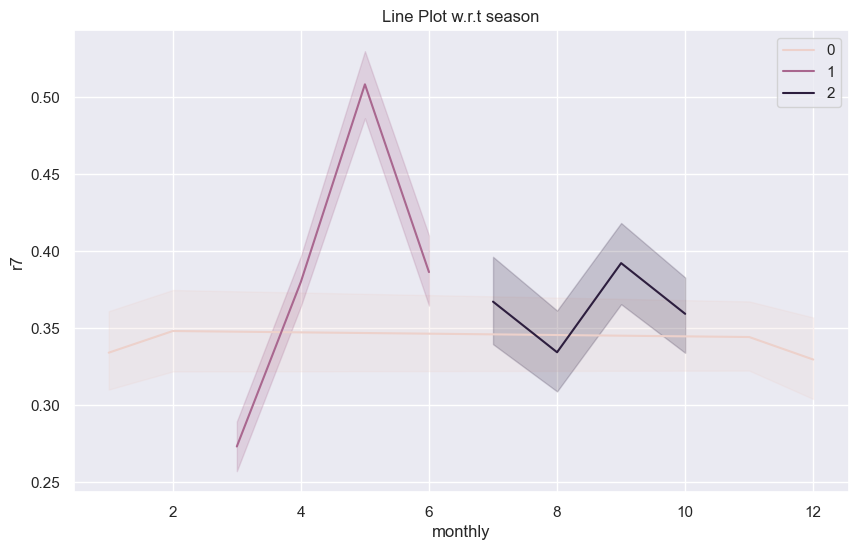

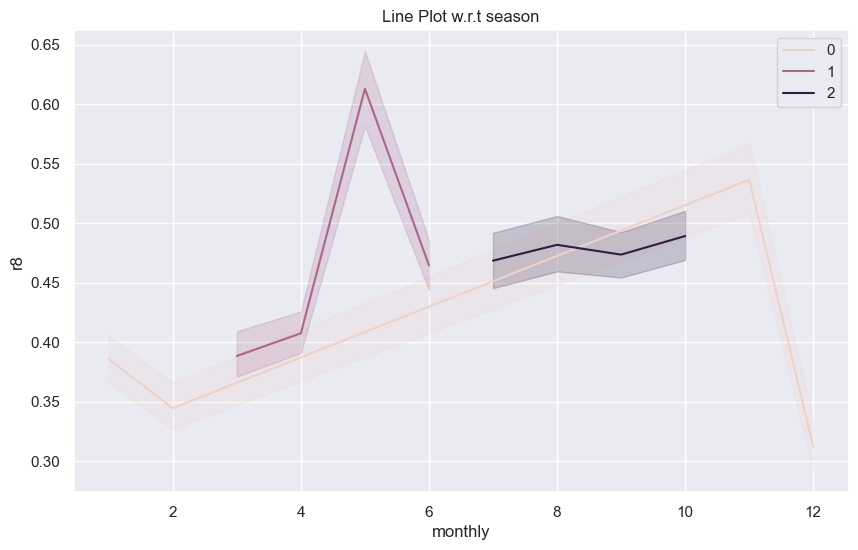

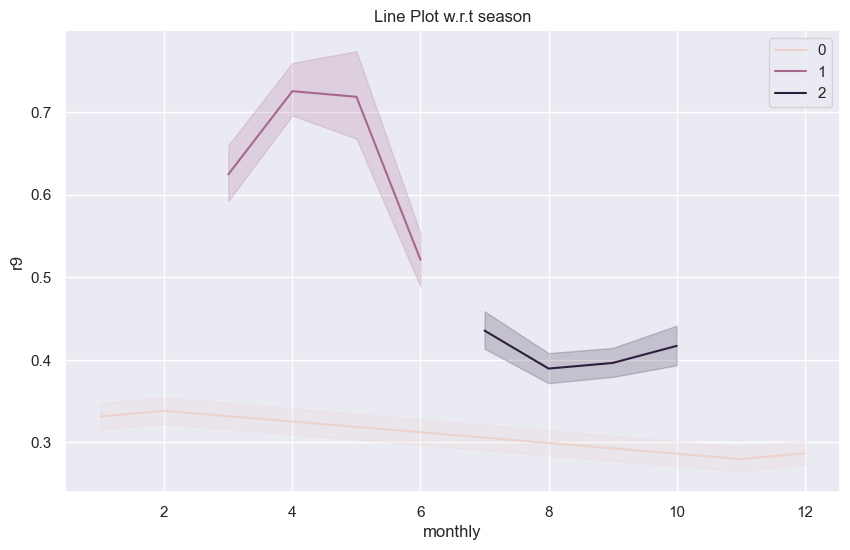

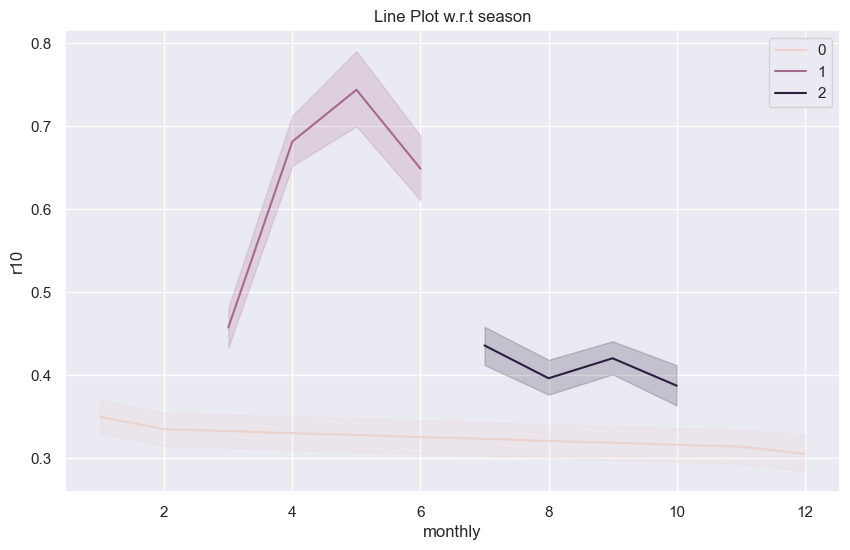

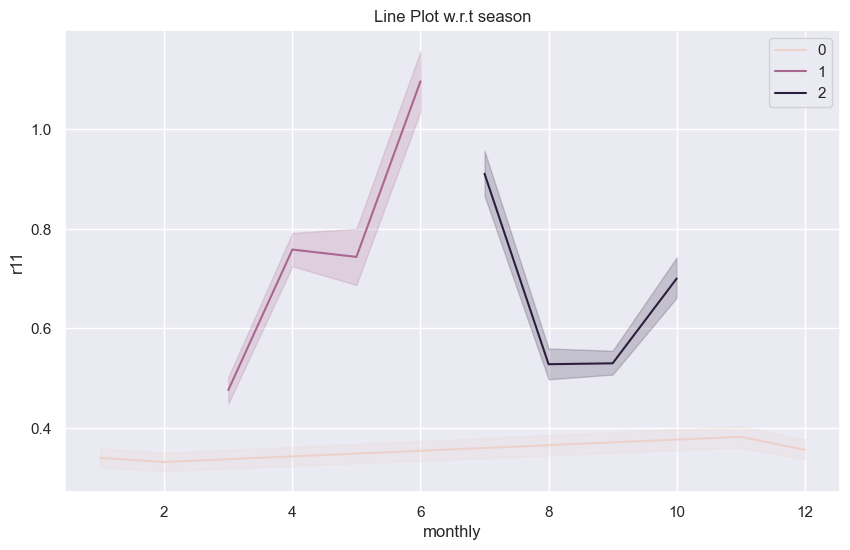

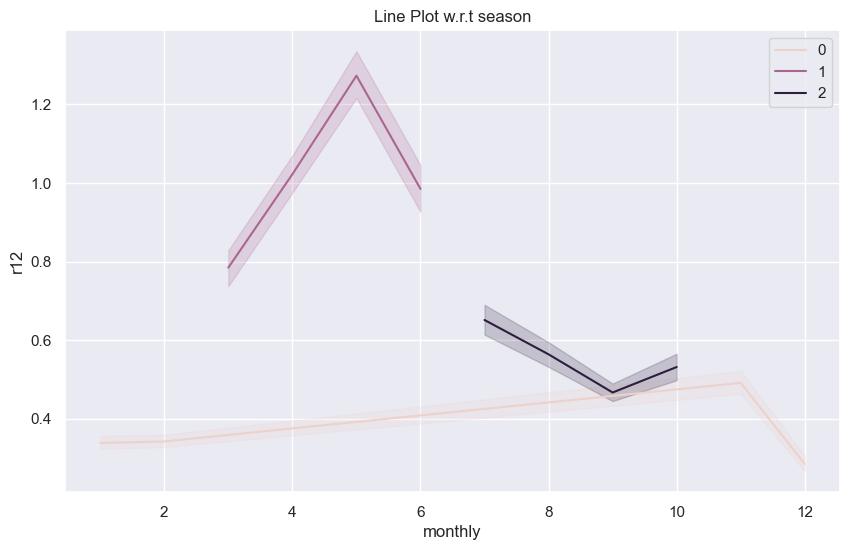

In [200]:
for i in range(1,13):
 sns.set_style('darkgrid')
 sns.set(rc={'figure.figsize': (10, 6)})

 # Create the line plot with multiple lines
 #sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r1'], label='Line 1')
 #sns.lineplot(data=df, x=df['Time'].dt.month, y= df['r1'], hue=df['season'], label='Line 2')
 sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r'+str(i)], hue=df['Season'], label='')

 plt.xlabel('monthly')
 plt.ylabel('r'+str(i))
 plt.title('Line Plot w.r.t season')

 plt.legend()
 plt.show()

In [37]:
#scaling full data
feature_cols = ['year', 'moy_date', 'doy_date', 'hour', 'temp','humid', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12']
X = df[feature_cols]
X = X.iloc[:,4:18]
X
scaler = StandardScaler()
df_R = scaler.fit_transform(X)

In [38]:
df_R.shape

(8760, 14)

ELBOW METHOD to determine no of clusters for TIMESERIES-KMEANS

In [54]:
#Converting dataframe to proper format for processing
df_t = df_monthly.transpose()
df_tt = df_t.values
df_t

Time  2017-01-31  2017-02-28  2017-03-31  2017-04-30  2017-05-31  2017-06-30  \
r1      0.094293    0.096209    0.097566    0.106485    0.111470    0.090282   
r2      0.062234    0.064416    0.081341    0.099859    0.117222    0.107681   
r3      0.074490    0.069350    0.134435    0.170777    0.090386    0.096042   
r4      0.042298    0.040448    0.049433    0.051286    0.081785    0.051697   
r5      0.116018    0.108354    0.154665    0.150043    0.138766    0.108547   
r6      0.077638    0.072600    0.094352    0.160878    0.144315    0.085792   
r7      0.070813    0.074061    0.056747    0.081433    0.111051    0.082896   
r8      0.100271    0.089270    0.100986    0.106074    0.160919    0.121315   
r9      0.095886    0.098002    0.184200    0.214528    0.212475    0.153060   
r10     0.111097    0.106191    0.146389    0.219824    0.240273    0.209135   
r11     0.072192    0.070326    0.102962    0.166684    0.163353    0.242999   
r12     0.088748    0.089832    0.208764    0.272635    0.340080    0.262631   

Time  2017-07-31  2017-08-31  2017-09-30  2017-10-31  2017-11-30  2017-12-31  
r1      0.113639    0.165061    0.124359    0.111640    0.119249    0.116162  
r2      0.078582    0.082729    0.075112    0.096091    0.079622    0.077054  
r3      0.096489    0.073652    0.082286    0.081796    0.078449    0.074023  
r4      0.053402    0.044958    0.043779    0.041706    0.038778    0.037342  
r5      0.141589    0.126002    0.135731    0.144912    0.122908    0.105669  
r6      0.083661    0.081154    0.092499    0.138049    0.085200    0.063800  
r7      0.078464    0.070875    0.084240    0.076637    0.073160    0.069784  
r8      0.122363    0.125912    0.123718    0.127885    0.140506    0.080651  
r9      0.127231    0.113386    0.115431    0.121655    0.080396    0.082496  
r10     0.139276    0.126319    0.134215    0.123398    0.099295    0.096509  
r11     0.201098    0.114680    0.115081    0.153531    0.081761    0.075823  
r12     0.172918    0.149423    0.123310    0.140748    0.129902    0.074382

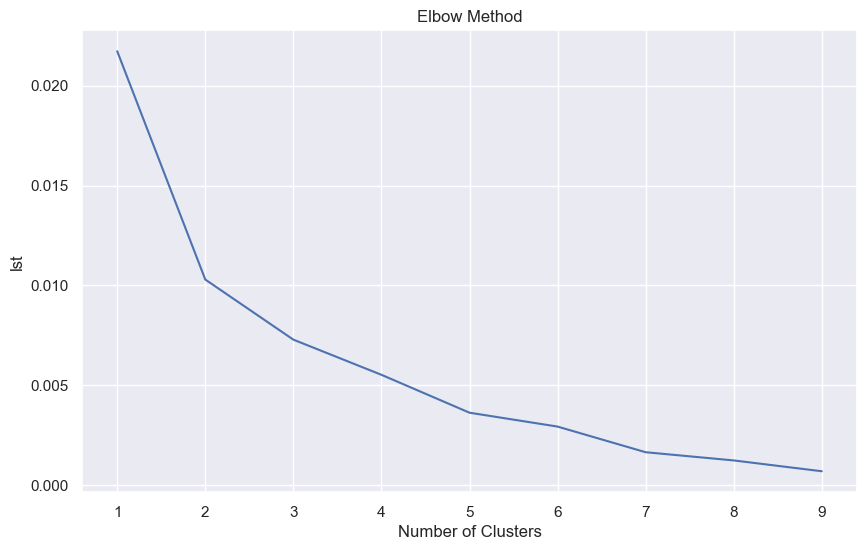

In [180]:
lst = []
#clusters for monthly data
for n_clusters in range(1, 10):
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters)\
    
    kmeans.fit(df_tt)
    lst.append(kmeans.inertia_)

plt.plot(range(1, 10), lst)
plt.xlabel('Number of Clusters')
plt.ylabel('lst')

plt.title('Elbow Method')
plt.show()

In [182]:
lst
#elbow at 5
#considering no of optimal clusters = 5

[0.021732276072345336,
 0.01029202201979029,
 0.007279899387450577,
 0.00551823079604682,
 0.003619318698452344,
 0.0029234517854414975,
 0.0016384873081588785,
 0.0012274429069965415,
 0.0006852237510085384]

#TIMESERIES KMEANS CLUSTERING ON MONTHLY DATA(using euclidean as distance metric)

In [162]:
n_clusters = 5
km = TimeSeriesKMeans(n_clusters = 5,n_init =3,random_state = 43)
km

TimeSeriesKMeans(n_clusters=5, n_init=3, random_state=43)

In [161]:
n_clusters = 5
ktime = TimeSeriesKMeans(n_clusters = 5,n_init =3,metric = "dtw",max_iter_barycenter = 10,random_state = 43)
ktime

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=5, n_init=3,
                 random_state=43)

In [163]:
df_tt.shape, df_t.index

((12, 12, 1),
 Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11',
        'r12'],
       dtype='object'))

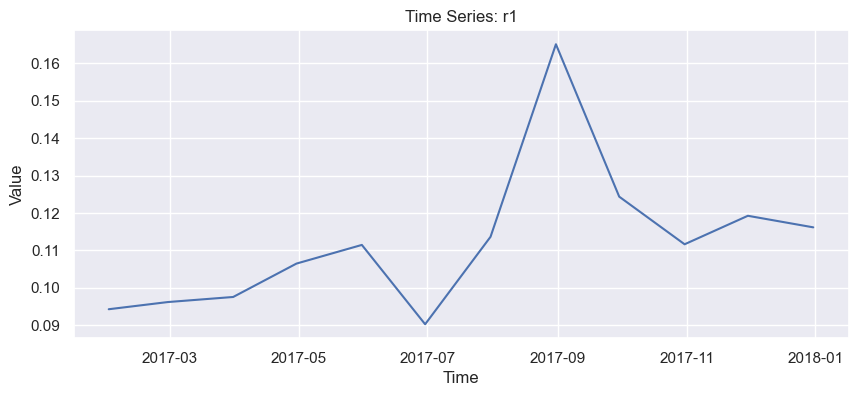

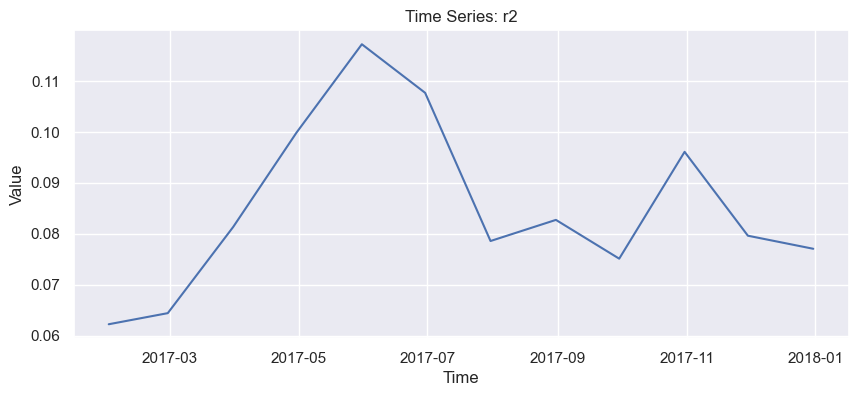

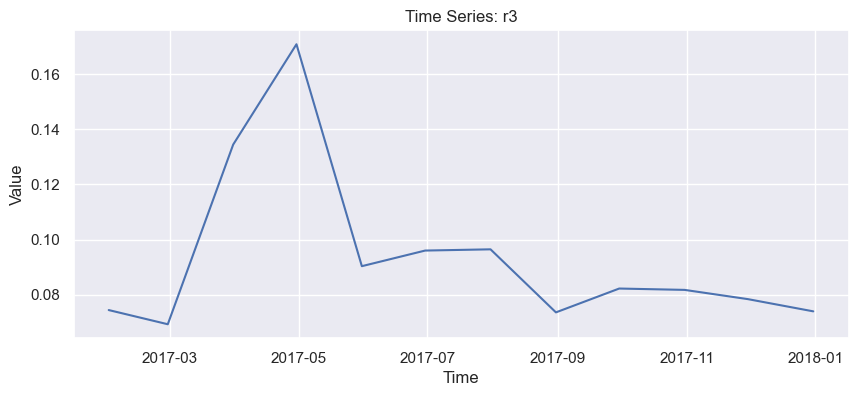

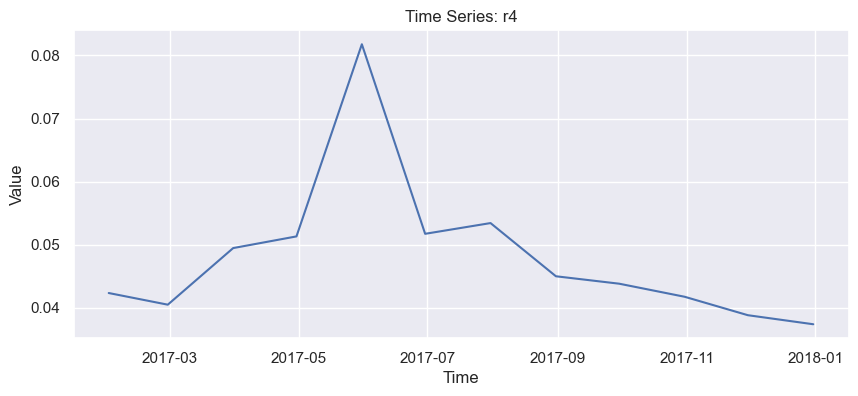

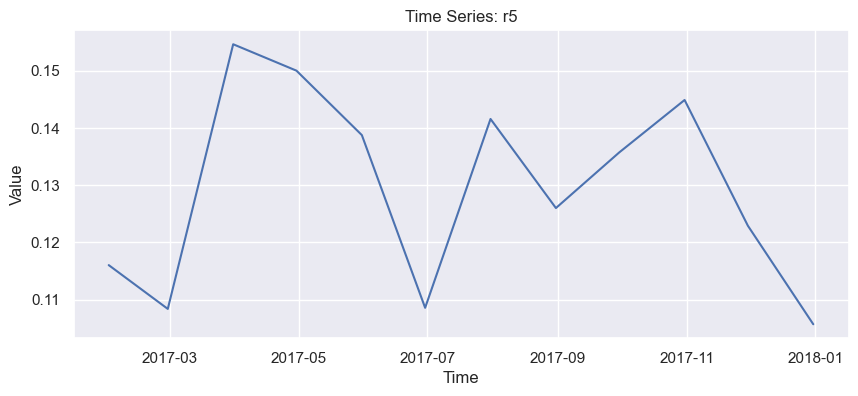

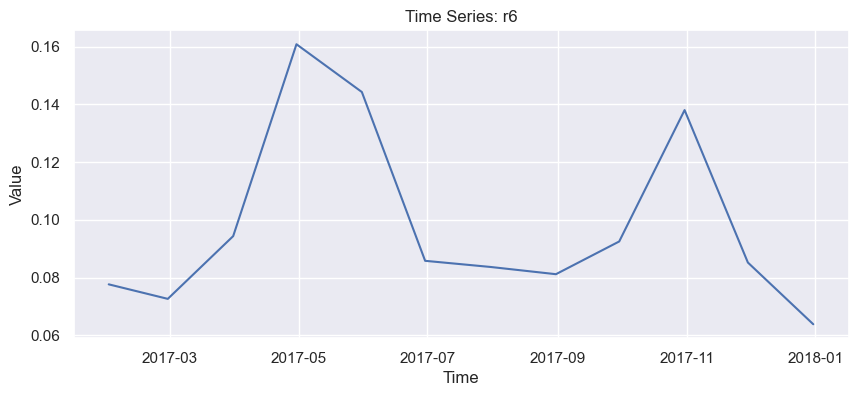

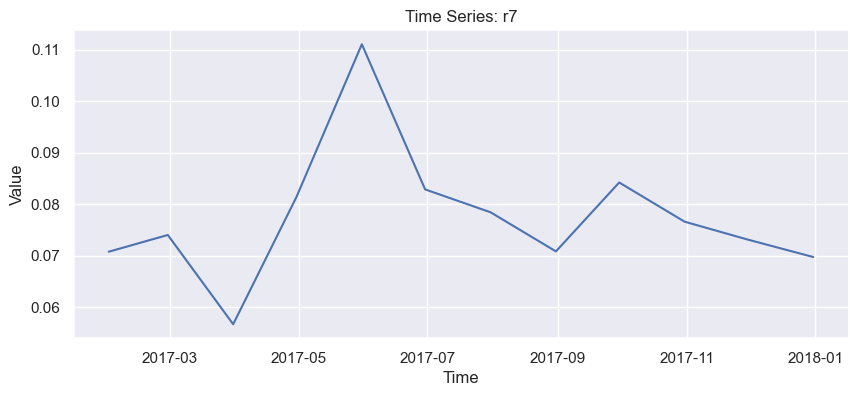

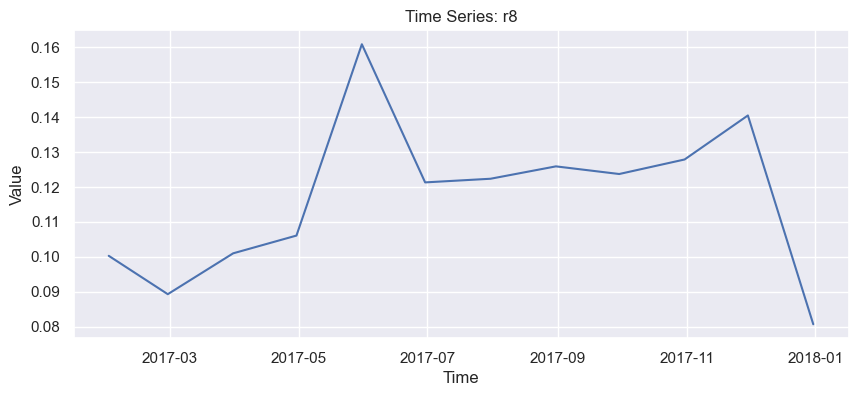

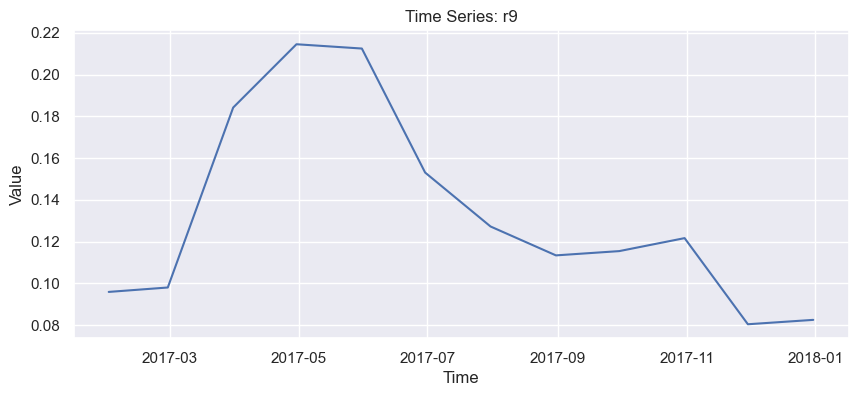

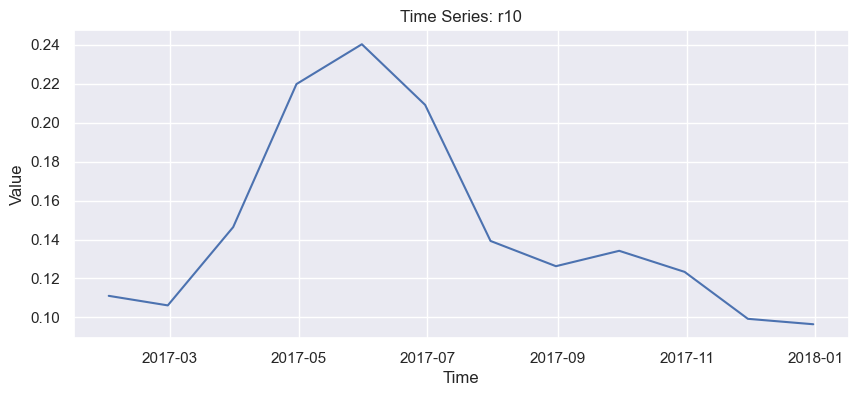

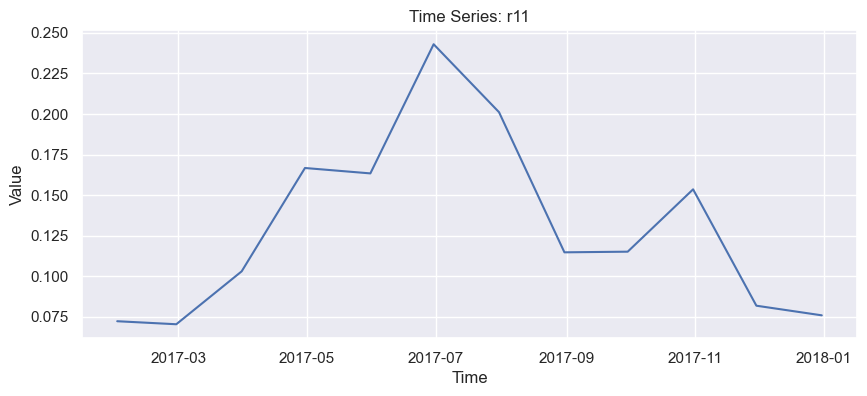

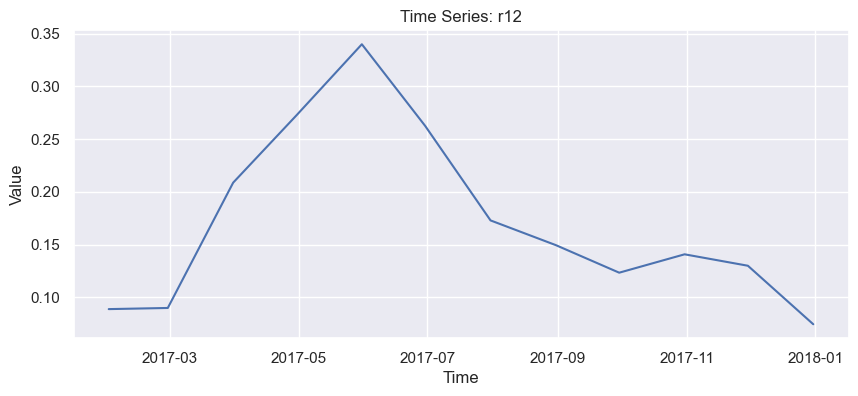

In [164]:
for col in df_monthly.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df_monthly.index, df_monthly[col])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Time Series: {col}')
    plt.show()

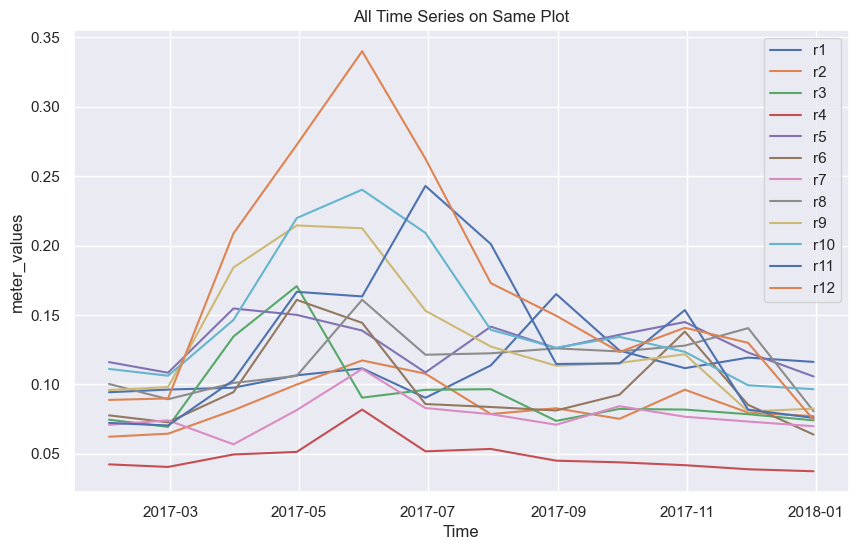

In [183]:
# Plotting all time series on the same plot
plt.figure(figsize=(10, 6))
for col in df_r.columns:
    plt.plot(df_monthly.index, df_monthly[col], label=col)
plt.xlabel('Time')
plt.ylabel('meter_values')
plt.title('All Time Series on Same Plot')
plt.legend()
plt.show()

In [165]:
df_tt = np.reshape(df_tt, (12, 12, 1))
ktime.fit(df_tt)#metric - dtw
km.fit(df_tt)#metric - euclidian
#MemoryError: Unable to allocate 585. MiB for an array with shape (8760, 8760) and data type float64 for hourly data

TimeSeriesKMeans(n_clusters=5, n_init=3, random_state=43)

In [ ]:
#PLOTTING clusters through euclidian and dtw method

In [166]:
cluster_labels_dtw = ktime.labels_
cluster_labels_euclidian = km.labels_

df_t['cluster_dtw'] = cluster_labels_dtw
df_t['cluster_euclidian'] = cluster_labels_euclidian

In [167]:
df_t

Time  2017-01-31 00:00:00  2017-02-28 00:00:00  2017-03-31 00:00:00  \
r1               0.094293             0.096209             0.097566   
r2               0.062234             0.064416             0.081341   
r3               0.074490             0.069350             0.134435   
r4               0.042298             0.040448             0.049433   
r5               0.116018             0.108354             0.154665   
r6               0.077638             0.072600             0.094352   
r7               0.070813             0.074061             0.056747   
r8               0.100271             0.089270             0.100986   
r9               0.095886             0.098002             0.184200   
r10              0.111097             0.106191             0.146389   
r11              0.072192             0.070326             0.102962   
r12              0.088748             0.089832             0.208764   

Time  2017-04-30 00:00:00  2017-05-31 00:00:00  2017-06-30 00:00:00  \
r1               0.106485             0.111470             0.090282   
r2               0.099859             0.117222             0.107681   
r3               0.170777             0.090386             0.096042   
r4               0.051286             0.081785             0.051697   
r5               0.150043             0.138766             0.108547   
r6               0.160878             0.144315             0.085792   
r7               0.081433             0.111051             0.082896   
r8               0.106074             0.160919             0.121315   
r9               0.214528             0.212475             0.153060   
r10              0.219824             0.240273             0.209135   
r11              0.166684             0.163353             0.242999   
r12              0.272635             0.340080             0.262631   

Time  2017-07-31 00:00:00  2017-08-31 00:00:00  2017-09-30 00:00:00  \
r1               0.113639             0.165061             0.124359   
r2               0.078582             0.082729             0.075112   
r3               0.096489             0.073652             0.082286   
r4               0.053402             0.044958             0.043779   
r5               0.141589             0.126002             0.135731   
r6               0.083661             0.081154             0.092499   
r7               0.078464             0.070875             0.084240   
r8               0.122363             0.125912             0.123718   
r9               0.127231             0.113386             0.115431   
r10              0.139276             0.126319             0.134215   
r11              0.201098             0.114680             0.115081   
r12              0.172918             0.149423             0.123310   

Time  2017-10-31 00:00:00  2017-11-30 00:00:00  2017-12-31 00:00:00  \
r1               0.111640             0.119249             0.116162   
r2               0.096091             0.079622             0.077054   
r3               0.081796             0.078449             0.074023   
r4               0.041706             0.038778             0.037342   
r5               0.144912             0.122908             0.105669   
r6               0.138049             0.085200             0.063800   
r7               0.076637             0.073160             0.069784   
r8               0.127885             0.140506             0.080651   
r9               0.121655             0.080396             0.082496   
r10              0.123398             0.099295             0.096509   
r11              0.153531             0.081761             0.075823   
r12              0.140748             0.129902             0.074382   

Time  cluster_dtw  cluster_euclidian  
r1              0                  0  
r2              3                  1  
r3              1                  1  
r4              3                  4  
r5              0                  0  
r6              1                  1  
r7              3              

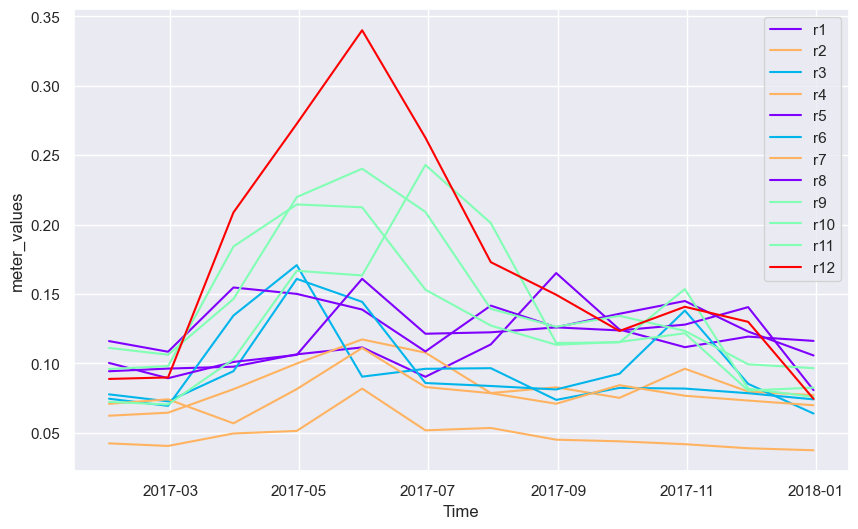

In [184]:
#PLOTTING CLUSTERS ON DTW METRIC - MONTHLY DATA

colors1 = cm.rainbow(np.linspace(0, 1, len(df_t['cluster_dtw'].unique())))

plt.figure(figsize=(10, 6))
for col, cluster in zip(df_r.columns, df_t['cluster_dtw']):
    plt.plot(df_monthly.index, df_monthly[col], color=colors1[cluster], label=col)
plt.xlabel('Time')
plt.ylabel('meter_values')
plt.legend()
plt.show()

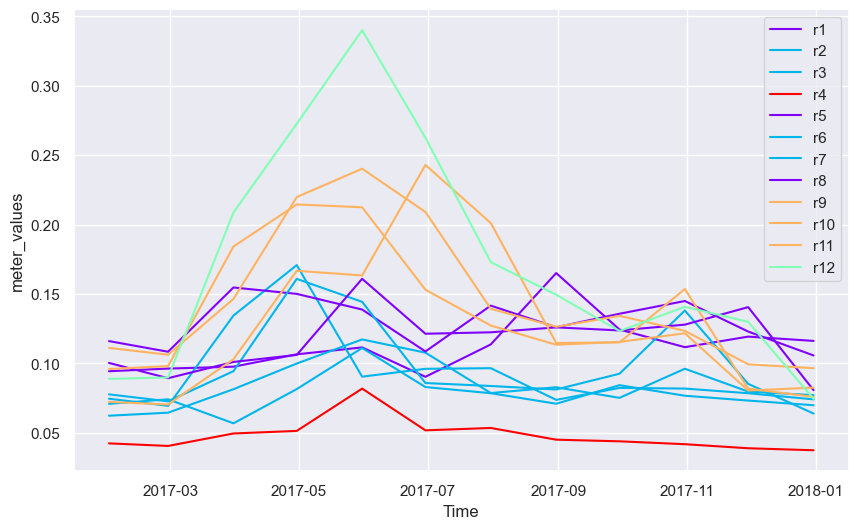

In [185]:
#PLOTTING CLUSTERS ON EUCLIDIAN METRIC - MONTHLY DATA

colors2 = cm.rainbow(np.linspace(0, 1, len(df_t['cluster_euclidian'].unique())))

plt.figure(figsize=(10, 6))
for col, cluster in zip(df_r.columns, df_t['cluster_euclidian']):
    plt.plot(df_monthly.index, df_monthly[col], color=colors2[cluster], label=col)
plt.xlabel('Time')
plt.ylabel('meter_values')
plt.legend()
plt.show()

In [186]:
monthly_dtw_silhouette_score = silhouette_score(df_t, df_t['cluster_dtw'])
monthly_euclidean_silhouette_score = silhouette_score(df_t, df_t['cluster_euclidian'])

In [187]:
monthly_dtw_silhouette_score , monthly_euclidean_silhouette_score
#very close

(0.5740499843301495, 0.48724917105372373)

In [189]:
ktime.fit(df_seasonal.T.values)#metric - dtw
km.fit(df_seasonal.T.values)#metric - euclidean

TimeSeriesKMeans(n_clusters=5, n_init=3, random_state=43)

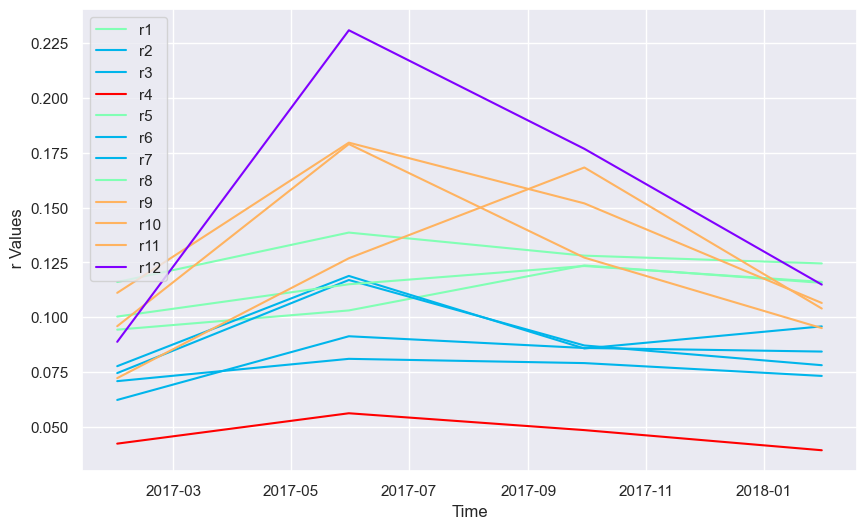

In [196]:
#TIMESERIES KMEANS CLUSTERING ON SEASONAL DATA - metric - DTW

n_clusters = 5
ktime = TimeSeriesKMeans(n_clusters = 5,n_init =3,metric = "dtw",max_iter_barycenter = 10,random_state = 43)
df_seasonal_2 = df_seasonal.T.copy()
ktime.fit(df_seasonal_2)#metric - dtw
cluster_labels_dtw = ktime.labels_
df_seasonal_2['cluster_dtw'] = cluster_labels_dtw
df_seasonal_2
colors2 = cm.rainbow(np.linspace(0, 1, len(df_seasonal_2['cluster_dtw'].unique())))

plt.figure(figsize=(10, 6))
for col, cluster in zip(df_r.columns, df_seasonal_2['cluster_dtw']):
    plt.plot(df_seasonal.index, df_seasonal[col], color=colors2[cluster], label=col)
plt.xlabel('Time')
plt.ylabel(' r Values')
plt.legend()
plt.show()

In [197]:
seasonal_dtw_score = silhouette_score(df_seasonal_2, df_seasonal_2['cluster_dtw'])
seasonal_dtw_score

0.8019538465654731

In [192]:
#TIMESERIES KMEANS CLUSTERING ON DAILY DATA - metric - DTW
n_clusters = 3
ktime = TimeSeriesKMeans(n_clusters = 5,n_init =3,metric = "dtw",max_iter_barycenter = 10,random_state = 43)
df_daily_2 = df_daily.T.copy()
ktime.fit(df_daily_2)#metric - dtw
km.fit(df_daily_2)#metric - dtw

cluster_labels_dtw = ktime.labels_
cluster_label_euclidian = km.labels_

df_daily_2['cluster_dtw'] = cluster_labels_dtw
df_daily_2['cluster_euclidian'] = cluster_label_euclidian

df_daily_2

Time  2017-01-01 00:00:00  2017-01-02 00:00:00  2017-01-03 00:00:00  \
r1               0.124860             0.087204             0.092243   
r2               0.089826             0.071865             0.066813   
r3               0.056452             0.041638             0.073722   
r4               0.038261             0.042655             0.041836   
r5               0.117630             0.143041             0.118627   
r6               0.074055             0.085098             0.067173   
r7               0.058350             0.046580             0.049825   
r8               0.101893             0.107272             0.089251   
r9               0.088906             0.089035             0.090522   
r10              0.120170             0.079903             0.108721   
r11              0.070720             0.085503             0.075236   
r12              0.081895             0.094425             0.097023   

Time  2017-01-04 00:00:00  2017-01-05 00:00:00  2017-01-06 00:00:00  \
r1               0.107651             0.097537             0.102405   
r2               0.079455             0.069462             0.067334   
r3               0.067165             0.082118             0.071304   
r4               0.047184             0.043347             0.041565   
r5               0.112654             0.115987             0.112455   
r6               0.062654             0.069307             0.074657   
r7               0.048228             0.059226             0.067301   
r8               0.092905             0.088199             0.097081   
r9               0.100239             0.093688             0.094436   
r10              0.128567             0.109613             0.109140   
r11              0.081267             0.070967             0.077343   
r12              0.101290             0.083271             0.085891   

Time  2017-01-07 00:00:00  2017-01-08 00:00:00  2017-01-09 00:00:00  \
r1               0.077603             0.083154             0.089822   
r2               0.068415             0.063487             0.060850   
r3               0.065490             0.053005             0.065171   
r4               0.036526             0.040233             0.043928   
r5               0.105379             0.112915             0.129769   
r6               0.081645             0.066432             0.065231   
r7               0.079123             0.078640             0.059700   
r8               0.120852             0.116298             0.095934   
r9               0.078454             0.100113             0.088146   
r10              0.153091             0.120716             0.100197   
r11              0.092596             0.105696             0.063111   
r12              0.072519             0.093495             0.080996   

Time  2017-01-10 00:00:00  ...  2017-12-24 00:00:00  2017-12-25 00:00:00  \
r1               0.085436  ...             0.090529             0.075435   
r2               0.048589  ...             0.073369             0.073342   
r3               0.058670  ...             0.075815             0.051039   
r4               0.035565  ...             0.044772             0.031889   
r5               0.187208  ...             0.112829             0.139283   
r6               0.069470  ...             0.024004             0.023893   
r7               0.072282  ...             0.075631             0.092593   
r8               0.118483  ...             0.038055             0.020068   
r9               0.091692  ...             0.062730             0.055710   
r10              0.092979  ...             0.113911             0.126451   
r11              0.056215  ...             0.057680             0.076562   
r12              0.087399  ...             0.030670             0.026141   

Time  2017-12-26 00:00:00  2017-12-27 00:00:00  2017-12-28 00:00:00  \
r1               0.071750             0.072606             0.079351   
r2               0.100812             0.073778             0.070625   
r3               0.065696 

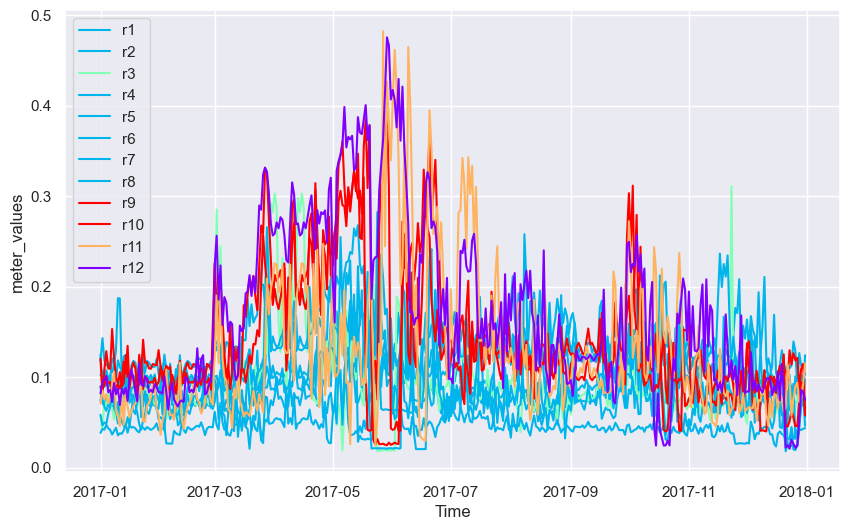

In [193]:
#plotting clusters throught dtw on DAILY DATA
colors1 = cm.rainbow(np.linspace(0, 1, len(df_daily_2['cluster_dtw'].unique())))

plt.figure(figsize=(10, 6))
for col, cluster in zip(df_r.columns, df_daily_2['cluster_dtw']):
    plt.plot(df_daily.index, df_daily[col], color=colors1[cluster], label=col)
plt.xlabel('Time')
plt.ylabel('meter_values')
plt.legend()
plt.show()

In [ ]:
daily_dtw_silhouette_score = silhouette_score(df_daily_2, df_daily_2['cluster_dtw'])
daily_euclidian_silhouette_score = silhouette_score(df_daily_2, df_daily_2['cluster_euclidian'])

daily_dtw_silhouette_score, daily_euclidian_silhouette_score
#very low scores

In [199]:
#TIMESERIES KMEANS CLUSTERING ON HOURLY DATA - metric - DTW


n_clusters = 5
ktime = TimeSeriesKMeans(n_clusters = 5,n_init =3,metric = "dtw",max_iter_barycenter = 10,random_state = 43)
df_hourly_2 = df_hourly.T.copy()
ktime.fit(df_hourly_2)#metric - dtw
cluster_labels_dtw = ktime.labels_
df_hourly_2['cluster_dtw'] = cluster_labels_dtw
df_hourly_2
col2 = cm.rainbow(np.linspace(0, 1, len(df_hourly_2['cluster_dtw'].unique())))

plt.figure(figsize=(10, 6))
for col, cluster in zip(df_r.columns, df_hourly_2['cluster_dtw']):
    plt.plot(df_hourly.index, df_hourly[col], color=col2[cluster], label=col)
plt.xlabel('Time')
plt.ylabel(' r Values')
plt.legend()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_5632\2472603776.py", line 4, in <module>
    ktime.fit(df_hourly_2)#metric - dtw
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py", line 780, in fit
    self._fit_one_init(X_, x_squared_norms, rs)
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py", line 662, in _fit_one_init
    self._assign(X)
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py", line 693, in _assign
    dists = self._transform(X)
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\tslearn\clustering\kmeans.py", line 684, in _transform
    return cdist_dtw(X, self.cluster_centers_, n_jobs=self.n_jobs,
  File "C:\Users\AVDEV03\Anaconda3\lib\site-packages\tslearn\metrics\dtw_v

TypeError: object of type 'NoneType' has no len()